In [1]:
#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, autoguide, HMCECS

/home/thebscotte/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/mojtaba142/hotel-booking")

In [3]:
#Read in data
df = pd.read_csv("hotel-booking/hotel_booking.csv")

In [4]:
#| include: false

#Check data read in correctly
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [5]:
#Create full arrival date column
df = df.assign(full_arrival_date = lambda x: pd.to_datetime(x['arrival_date_year'].astype(str) + '-' +
                                                        x['arrival_date_month'].astype(str) + '-' +
                                                        x['arrival_date_day_of_month'].astype(str)))

In [6]:
#| include: false

#Get names of all columns
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card', 'full_arrival_date'],
      dtype='object')

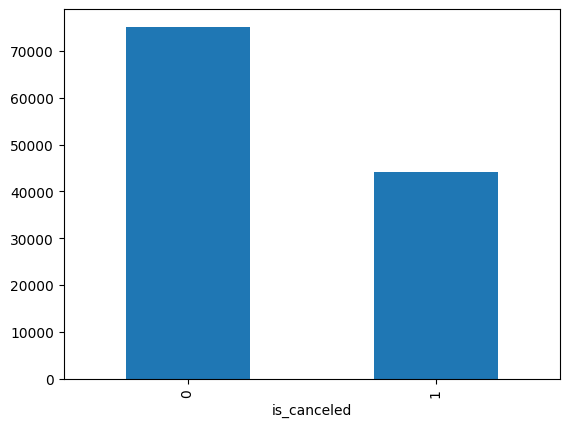

In [7]:
#| include: false

#Look at value counts of 0 and 1 in dataset
df['is_canceled'].value_counts().plot(kind='bar');

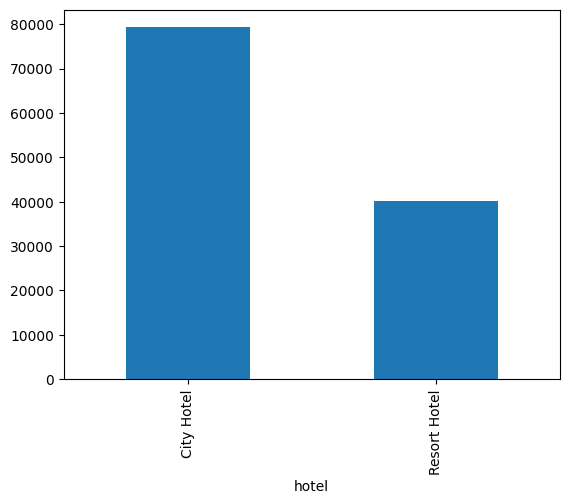

In [8]:
#| include: false

#Look at count of different hotel type
df['hotel'].value_counts().plot(kind='bar');

In [9]:
#| include: false

#Generate basic summary statistics
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,full_arrival_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016-08-28 16:39:45.727447808
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2015-07-01 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016-03-13 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016-09-06 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017-03-18 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-08-31 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,NaN


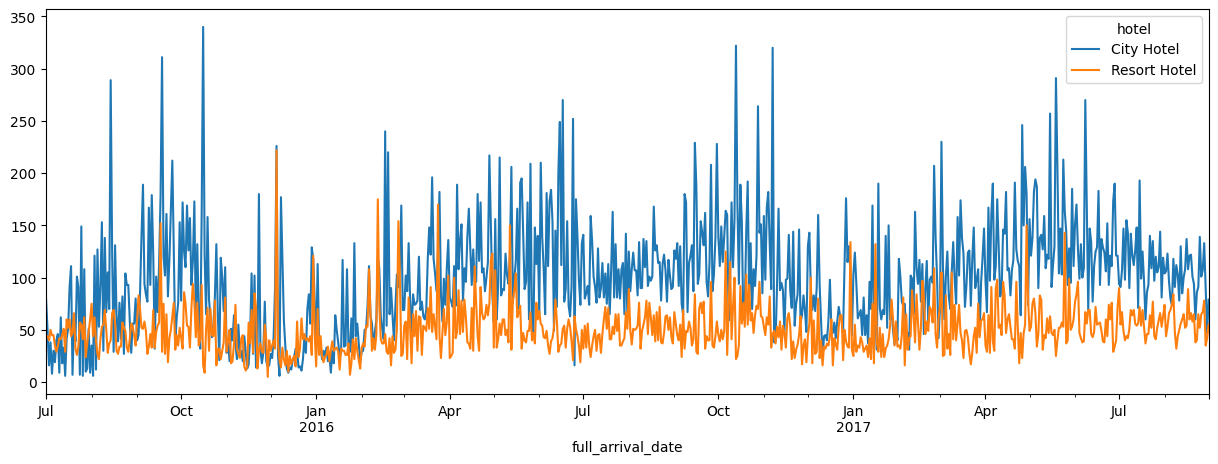

In [10]:
#| include: false

#Look at count of bookings by arrival date
(df.assign(full_arrival_date = lambda x: pd.to_datetime(x['arrival_date_year'].astype(str) + '/' +
                                                        x['arrival_date_month'].astype(str) + '/' +
                                                        x['arrival_date_day_of_month'].astype(str)))
 .groupby(['full_arrival_date', 'hotel'])
 .size()
 .reset_index(name='count')
 .pivot_table(index='full_arrival_date', columns='hotel', values='count').plot(figsize=(15,5)));

#plt.savefig('plot.png')

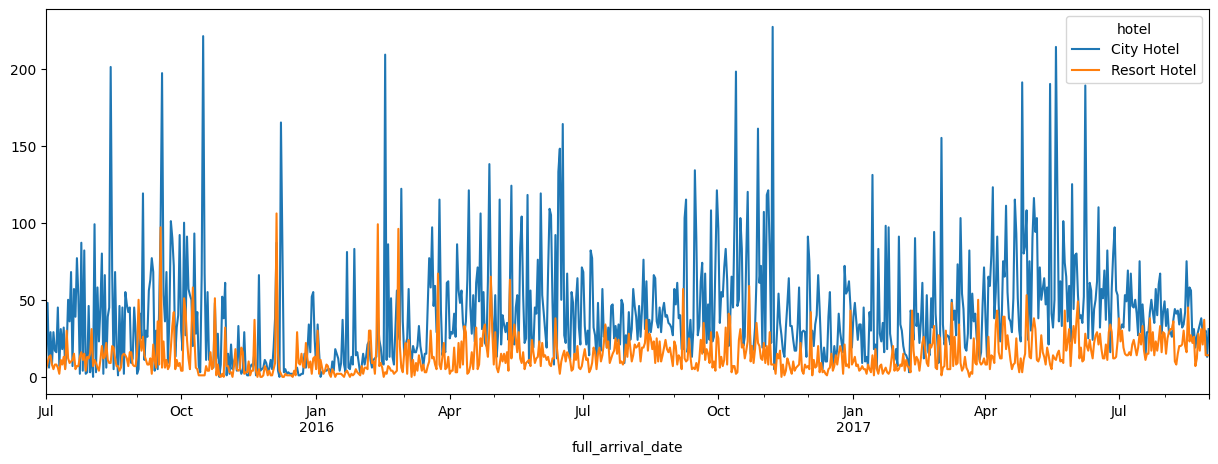

In [11]:
#| include: false

#Look at number of cancelations over time by arrival date (or supposed arrival date)
(df.assign(full_arrival_date = lambda x: pd.to_datetime(x['arrival_date_year'].astype(str) + '/' +
                                                        x['arrival_date_month'].astype(str) + '/' +
                                                        x['arrival_date_day_of_month'].astype(str)))
 .groupby(['full_arrival_date', 'hotel'])['is_canceled']
 .sum()
 .reset_index(name='count')
 .pivot_table(index='full_arrival_date', columns='hotel', values='count')
 .plot(figsize=(15,5)));

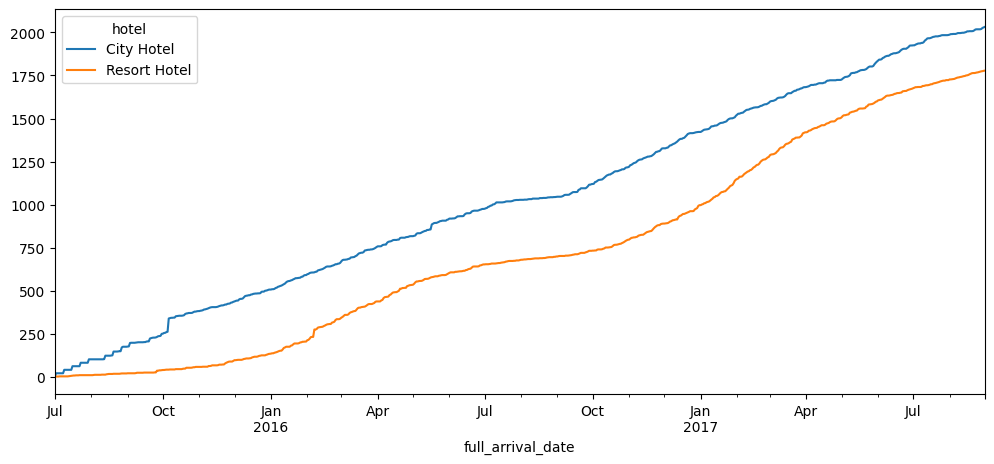

In [12]:
#| include: false

#Look at rolling sum of repeated guests booking overtime, split by hotel type
(df.groupby(['full_arrival_date', 'hotel'])['is_repeated_guest'].sum()
 .reset_index(name='sum_guests')
 .assign(cumulative_sum = lambda x: x.groupby(['hotel'])['sum_guests'].cumsum())
 .pivot_table(index='full_arrival_date', columns='hotel', values='cumulative_sum')
 .plot(figsize=(12,5)));

In [13]:
#| include: false

#Look at different market segments and respective counts
df['market_segment'].value_counts()

market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64

In [14]:
#| include: false

#Look at different distribution channels and respective counts
df['distribution_channel'].value_counts()

distribution_channel
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: count, dtype: int64

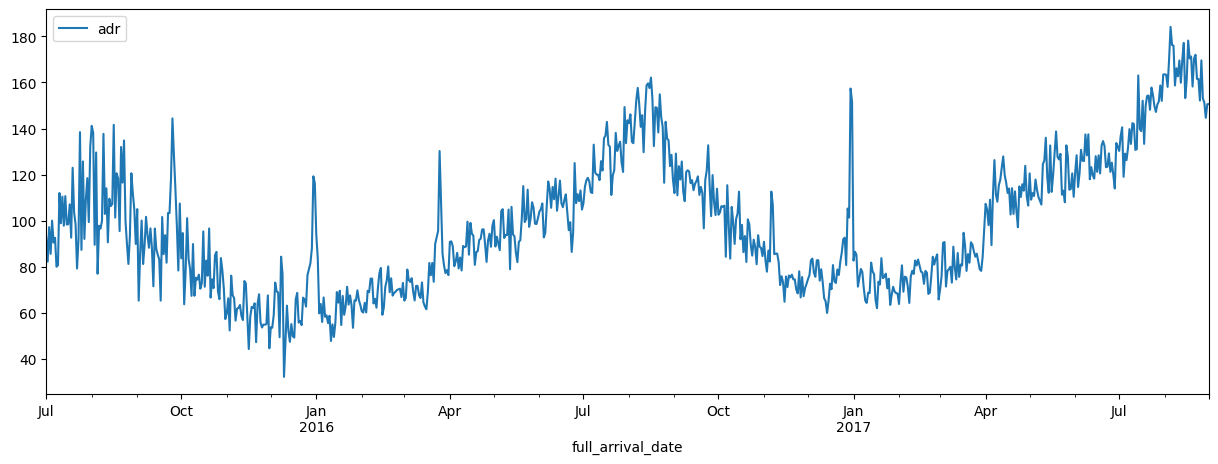

In [15]:
#| include: false

#Plot view of adr over time
(df.groupby(['full_arrival_date']).agg({'adr':'mean'})
 .plot(figsize=(15,5)));

# Introduction

TA-MU Hotels is a small, privately owned hotel business. Currently, TA-MU Hotels owns two hotels: One in the heart of Manhattan, NYC and another in Cancun, Mexico. TA-MU Hotels is looking to grow its business and hired us (TheBayesianBandit LLC) to look into how their respective hotels are performing. Specifically, our goal is to generate more profit for TA-MU Hotels by identifying profitable opportunities from their hotel booking data.

# Background on Data

The dataset supplied to us contained a total of 119,390 rows with 37 columns. Columns ranged from information containing arrival information of guests, number of guests (adults, children, babies), to marketing information such as lead time and distribution channel. The data was generally clean with the exception of a few incorrect data types. Additionally, there were a few rows of observation that were extreme outliers (ie 50+ guests for a single booking) that did not pertain to the general business model of TA-MU Hotels, so they were eventually removed during the analysis for more accurate analysis of guest booking data.

The analysis of this report was done with Python. The creation of this report was done with Quarto. The raw data for this report can be found <a href="https://www.kaggle.com/datasets/mojtaba142/hotel-booking">here</a>.

# Overview of TA-MU Hotels Business Performance

## Revenue Generation

As noted in the introduction, TA-MU Hotels currently has two operating hotels. @fig-adr-1 shows the current revenue generation by TA-MU Hotels on a daily level. The top panel indicates the total revenue of both hotels while the bottom panel shows the amount of revenue generated by each hotel.

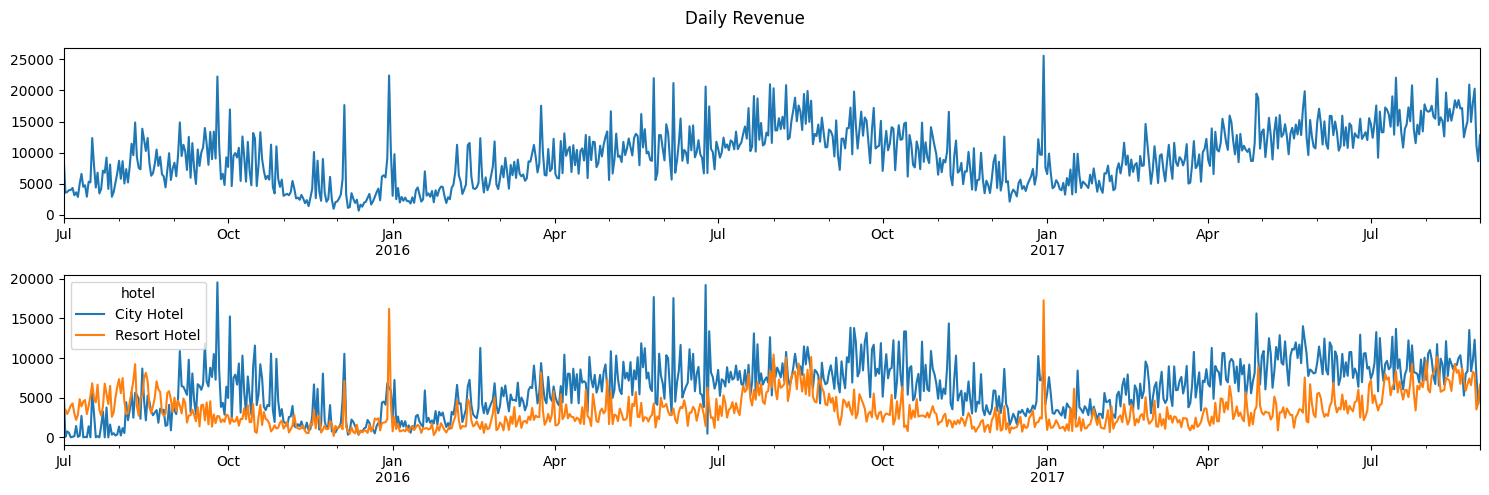

In [16]:
#| label: fig-adr-1
#| fig-cap: "Time series plot of daily revenue generation of TA-MU Hotels. Top panel shows combined revenue whereas bottom panel shows revenue split by hotel location."

#Calculate revenue by full_arrival_date split by hotel type by summing up adr (uninclude canceled bookings)
fig, ax = plt.subplots(2,1,figsize=(15,5))

(df.query("is_canceled == 0")
 .groupby(['full_arrival_date'])
 .agg({'adr':'sum'})
 .reset_index()
 .pivot_table(index='full_arrival_date', values='adr')
 .fillna(0)
 .plot(ax=ax[0], legend=False)
)

ax[0].set_xlabel("")

(df.query("is_canceled == 0")
 .groupby(['full_arrival_date', 'hotel'])
 .agg({'adr':'sum'})
 .reset_index()
 .pivot_table(index='full_arrival_date', columns='hotel', values='adr')
 .fillna(0)
 .plot(ax=ax[1])
)

ax[1].set_xlabel("")
fig.suptitle("Daily Revenue")
fig.tight_layout();

@fig-adr-1 shows a general trend of increasing revenue for the company. There also appears to be indications of seasonality in the total company revenue as revenue slows during the winter months and rises again in the spring and summer. Viewing the revenue splits by hotel types, generally the city hotel generates more revenue throughout the year. The resort hotel appears to have large spikes in revenue during the holiday season (December-January). In general, revenue for TA-MU Hotels appears to be gradually increasing over time.

While the city hotel generally brings in the most revenue per day, @fig-adr-2 shows that the resort hotel during peak times has more money generated per guest. There appears to be a recurring trend of high spending guests between the months of July-September at the resort hotel.

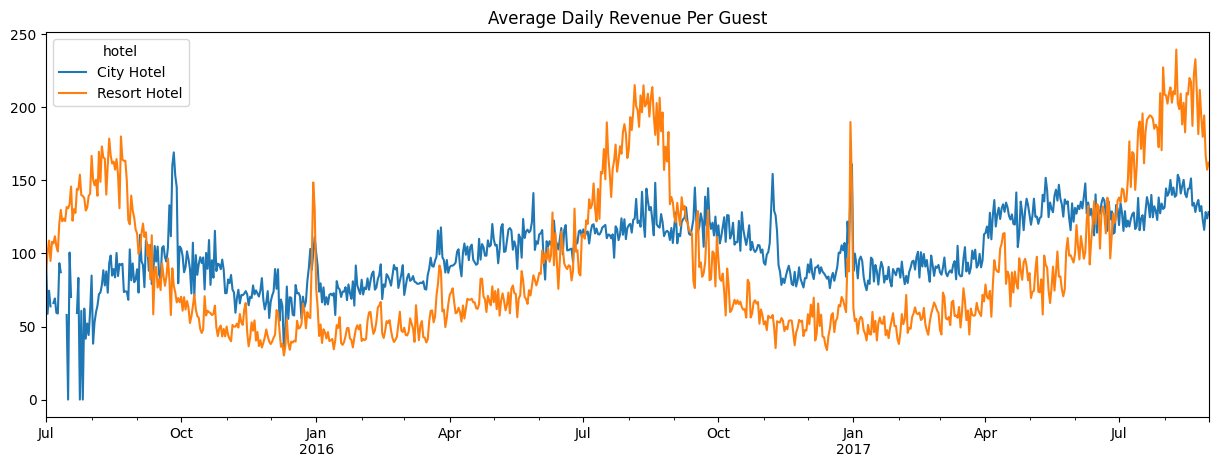

In [17]:
#| label: fig-adr-2
#| fig-cap: "Time series plot of average revenue per guest on a daily scale."

#Plot average adr split by hotel type (uninclude canceled reservations)
fig, ax = plt.subplots(figsize=(15,5))

(df.query("is_canceled == 0")
 .groupby(['full_arrival_date', 'hotel'])
 .agg({'adr':'mean'})
 .reset_index()
 .pivot_table(index='full_arrival_date', columns='hotel', values='adr')
 .plot(ax=ax)
)

ax.set_xlabel("")
ax.set_title("Average Daily Revenue Per Guest");

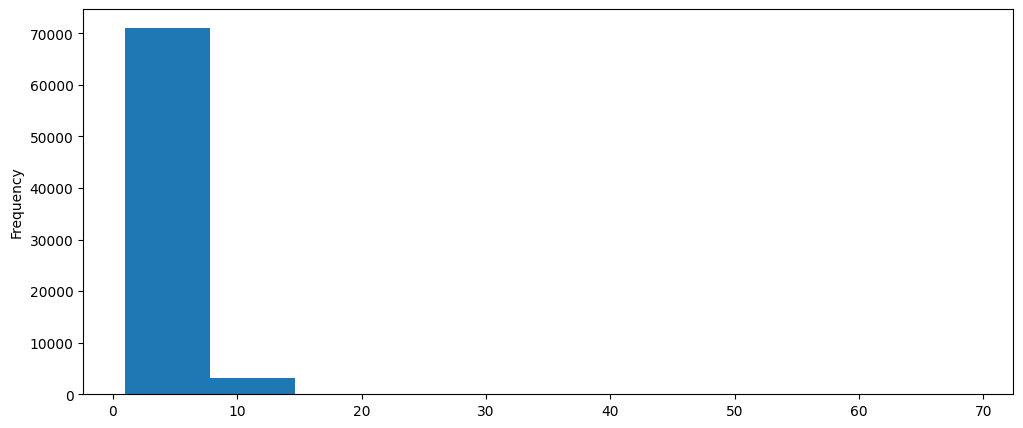

In [18]:
#| include: false

#Get distribution of number of nights per booking
(df.query("is_canceled == 0")
 .assign(total_nights = lambda x: x['stays_in_week_nights'] + x['stays_in_weekend_nights'])
 .query("total_nights > 0")['total_nights']
 .plot(kind='hist', figsize=(12,5)));

While @fig-adr-1 and @fig-adr-2 show the daily revenue generation, we were also curious to see if the amount of money spent by guests differed by their respective length of stay. @fig-adr-3 breaks down the average amount of money spent per night by the length of stay for each booking.

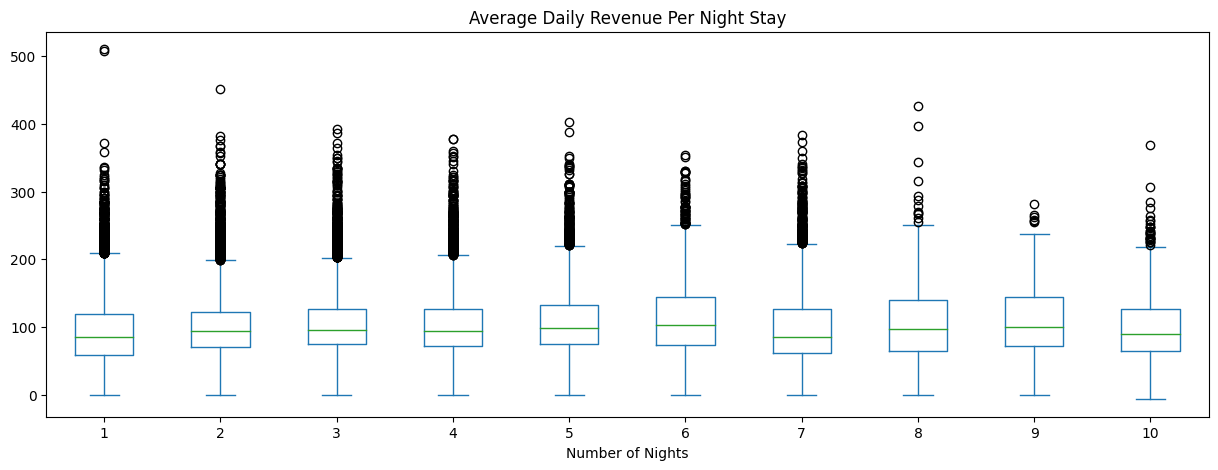

In [19]:
#| label: fig-adr-3
#| fig-cap: "Box plot of average amount of revenue spent per night stay."

#Create box-and-whisker plot of adr by length of stay (num nights <= 10)
fig, ax = plt.subplots(figsize=(15,5))

(df.query("is_canceled == 0")
 .assign(total_nights = lambda x: x['stays_in_week_nights'] + x['stays_in_weekend_nights'])
 .query("total_nights > 0")
 .query("total_nights <= 10")
 .plot(kind='box', by='total_nights', column='adr', ax=ax)
)

ax.set_xlabel("Number of Nights")
ax.set_title("Average Daily Revenue Per Night Stay");

From @fig-adr-3, we see that there is no major difference between the average amount of money spent per night by the length of stay. Customers who only stay one night spend about the same on average per night as those who stay three nights. This result is again seen in @fig-adr-4 when we take at each hotel's average customer expenditure per night.

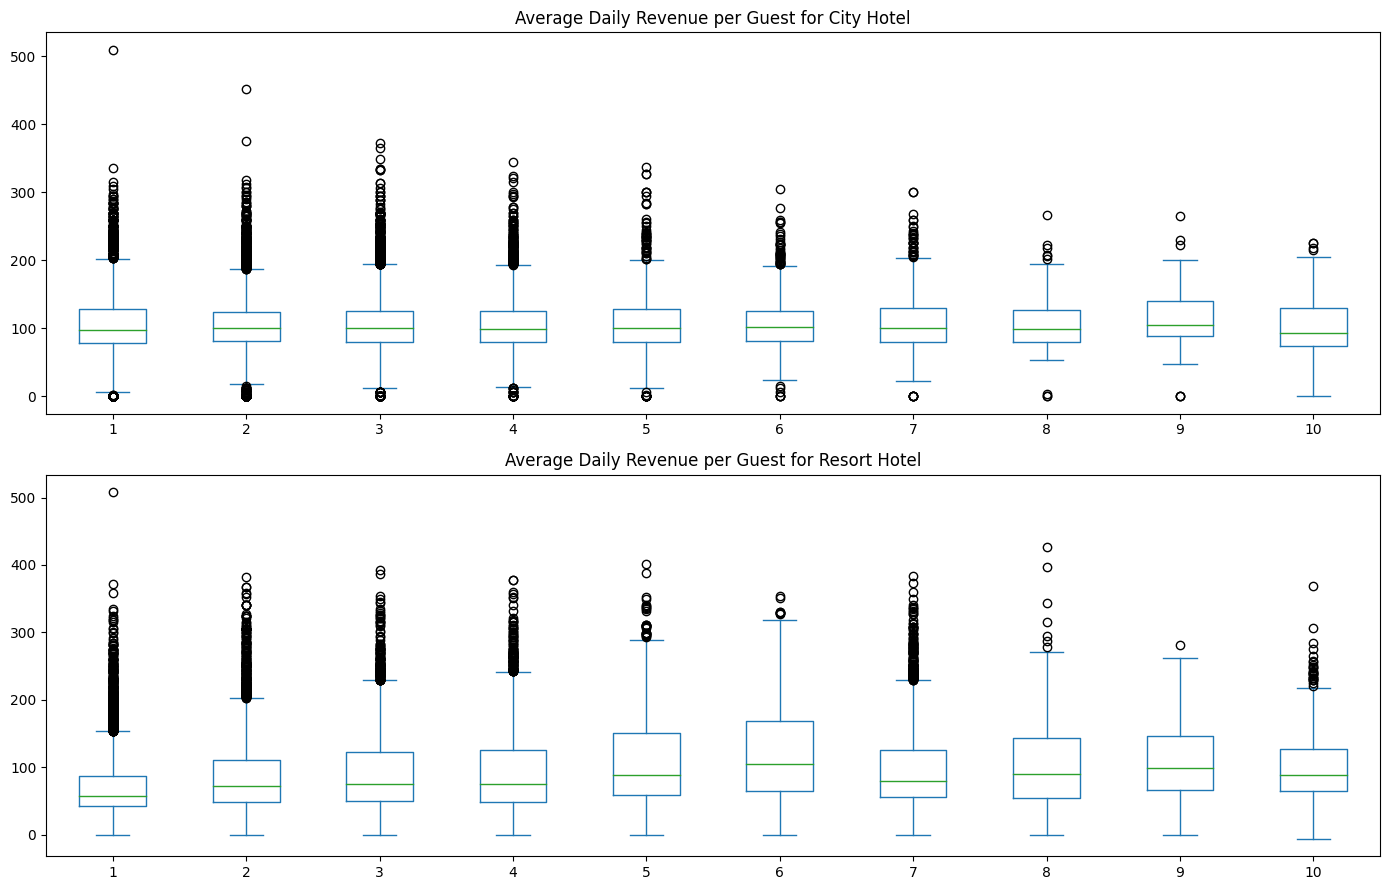

In [20]:
#| label: fig-adr-4
#| fig-cap: "Box plot of average amount of revenue spent per night stay by each hotel."

#Create box-and-whisker plot of adr by length of stay, split by hotel type in separate figures
fig, ax = plt.subplots(2,1, figsize=(14,9))

(df.query("is_canceled == 0 and hotel == 'City Hotel'")
 .assign(total_nights = lambda x: x['stays_in_week_nights'] + x['stays_in_weekend_nights'])
 .query("total_nights > 0")
 .query("total_nights <= 10")
 .plot(kind='box', by=['total_nights'], column='adr', ax=ax[0])
)

(df.query("is_canceled == 0 and hotel == 'Resort Hotel'")
 .assign(total_nights = lambda x: x['stays_in_week_nights'] + x['stays_in_weekend_nights'])
 .query("total_nights > 0")
 .query("total_nights <= 10")
 .plot(kind='box', by=['total_nights'], column='adr', ax=ax[1])
)

ax[0].set_title("Average Daily Revenue per Guest for City Hotel")
ax[1].set_title("Average Daily Revenue per Guest for Resort Hotel")

fig.tight_layout();

## Client Demographics

Identifying who are our clients generating revenue for our business is the first step in understanding how we strategize to generate more revenue. @fig-client-1 shows the daily average number of people per booking at each hotel.

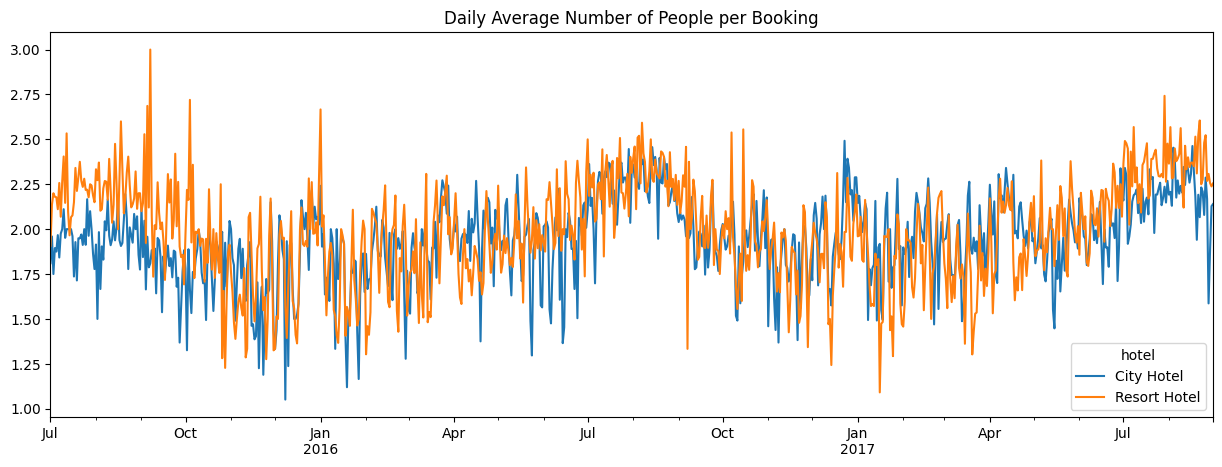

In [21]:
#| label: fig-client-1
#| fig-cap: "Time series plot of average number of people per booking, split by hotel type."

#Look at average number of people per booking at each hotel over time
fig, ax = plt.subplots(figsize=(15,5))

(df.assign(num_guests = lambda x: x['children'] + x['babies'] + x['adults'])
 .groupby(['full_arrival_date', 'hotel'])
 .agg({'num_guests':'mean'})
 .reset_index()
 .pivot_table(index='full_arrival_date', columns='hotel', values='num_guests')
 .plot(ax=ax)
)

ax.set_title("Daily Average Number of People per Booking")
ax.set_xlabel("");

It appears that on average, the lines for both hotels hover mostly in the two people per booking area. There are a few highs and lows indicating that the average at times could be close to one guest per booking or three guests per booking. @tbl-client-1 goes into more detail by looking into specific demographic details and the percent of bookings each demographic represents.

| Hotel | Number of Adults | Kids in Booking | Customer Type | % Bookings |
|-------|------------------|------|---------------|------------|
| City Hotel | 2 | No | Transient | 33% |
| Resort Hotel | 2 | No | Transient | 18% |
| City Hotel | 2 | No | Transient-Party | 10% |
| City Hotel | 1 | No | Transient | 9% |
| Resort Hotel | 2 | No | Transient-Party | 4%

: Client Demographics {#tbl-client-1}

@tbl-client-1 shows the top five demographics based on percent of bookings. From the table, we see that our biggest client demographic is two adults of customer type transient (when the booking is not part of a group or contract and is not associated with another transient booking) and no kids in the booking. Both the city hotel and resort hotel have this demographic as their most popular client demographic, with over 50% of total company bookings from this demographic alone. Additionally, in 3rd and 5th place respectively are two adult parties as well but of transient party (booked with a connection to at least one other transient booking).

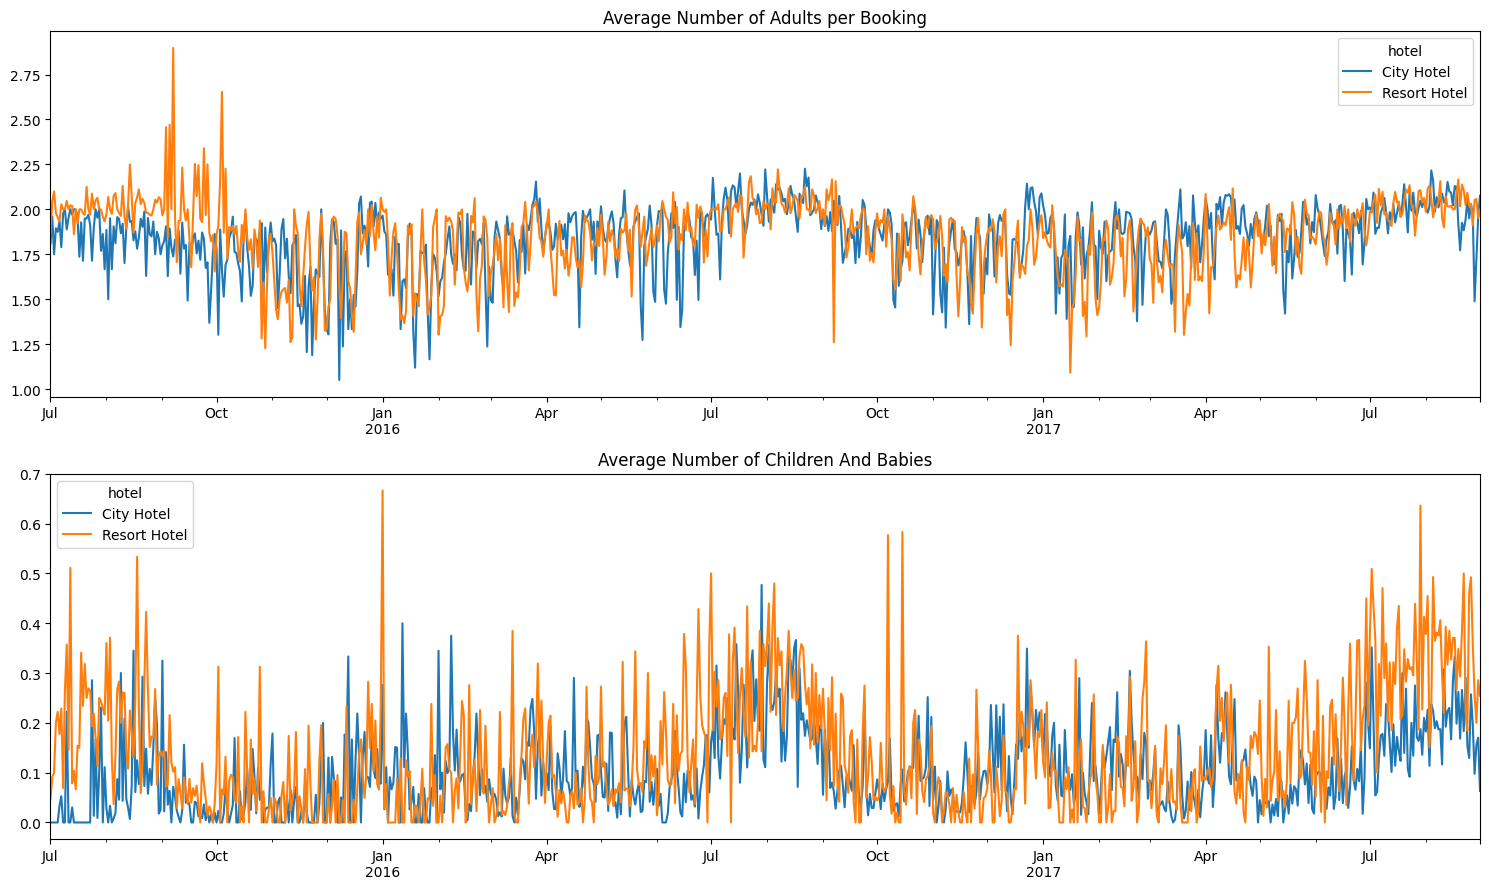

In [22]:
#| include: false

#Look at average number of adults per booking at each hotel over time
fig, axes = plt.subplots(2,1, figsize=(15,9))

(df.groupby(['full_arrival_date', 'hotel'])['adults'].mean()
 .unstack()
 .plot(title='Average Number of Adults per Booking', ax=axes[0]))

#Look at average number of children + babies per booking at each hotel over time
(df.assign(sum_children_babies = lambda x: x['children'] + x['babies'])
 .groupby(['full_arrival_date', 'hotel'])['sum_children_babies'].mean()
 .unstack()
 .plot(title="Average Number of Children And Babies", ax=axes[1]))


axes[0].set_xlabel("")
axes[1].set_xlabel("")

fig.tight_layout();

## Lost Revenue

<b>Important Note</b>: For the column "is_canceled", it is a binary classification for canceled = 1 and not canceled = 0.

Now that we have identified TA-MU Hotels' current revenue generation trends and their primary clients, we will identify areas of improvement based on lost revenue. Lost revenue primarily comes from canceled bookings. We see in @fig-lost-rev-1 that the city hotel, while generating the most bookings overall, also has a larger proportion of canceled bookings than the resort hotel.

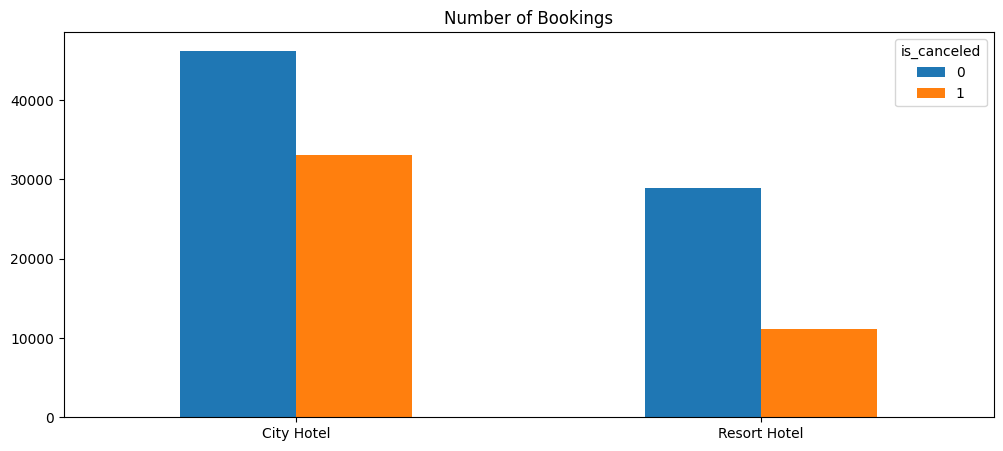

In [23]:
#| label: fig-lost-rev-1
#| fig-cap: "Bar plot of number of not-canceled/canceled bookings broken up by hotel type."

#Look at counts of cancelations and non-cancelations by hotel type
fig, ax = plt.subplots()

(df.groupby(['hotel', 'is_canceled'])
 .size()
 .unstack()
 .plot(kind='bar', figsize=(12,5), ax=ax)
)

ax.set_xlabel("")
ax.set_title("Number of Bookings")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

In order to quantify the impact of these cancelations, @fig-lost-rev-2 shows the daily gain of non-canceled bookings vs the daily loss of canceled bookings for each hotel.

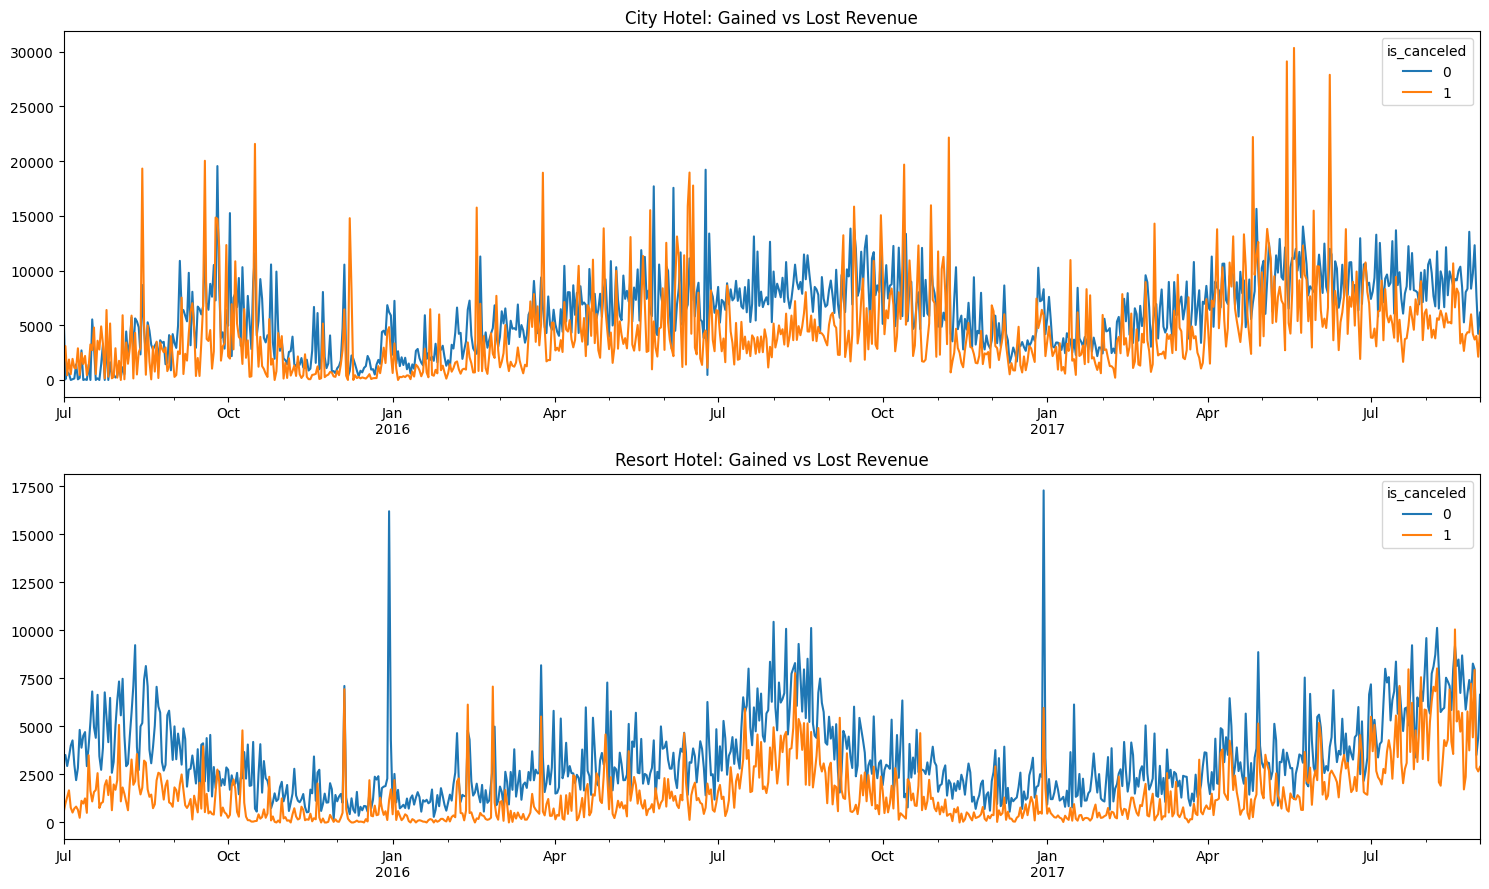

In [24]:
#| label: fig-lost-rev-2
#| fig-cap: "Top panel shows time series plot of daily revenue gained vs daily revenue lost based on non-canceled/canceled bookings in city hotel. Bottom panel shows time series plot of daily revenue gained vs daily revenue lost based on non-canceled/canceled bookings in resort hotel."

#Look at total adr gained vs lost in each hotel in separate figures
fig, ax = plt.subplots(2,1, figsize=(15,9))

(df.query("hotel == 'City Hotel'")
 .groupby(['full_arrival_date', 'is_canceled'])
 .agg({'adr':'sum'})
 .reset_index()
 .pivot_table(index='full_arrival_date', columns='is_canceled', values='adr')
 .fillna(0)
 .plot(ax=ax[0], title="City Hotel: Gained vs Lost Revenue"))

(df.query("hotel == 'Resort Hotel'")
 .groupby(['full_arrival_date', 'is_canceled'])
 .agg({'adr':'sum'})
 .reset_index()
 .pivot_table(index='full_arrival_date', columns='is_canceled', values='adr')
 .fillna(0)
 .plot(ax=ax[1], title="Resort Hotel: Gained vs Lost Revenue"))

ax[0].set_xlabel("")
ax[1].set_xlabel("")

fig.tight_layout()

As we can see in @fig-lost-rev-2, the city hotel has quite a few times where lost revenue overtakes revenue gained. Several times we see large spikes in canceled bookings and subsequently large spikes in lost revenue. In contrast, it appears the resort hotel rarely has any days where lost revenue overtakes revenue gained. To further dive into the details of all this lost revenue, we can view @tbl-lost-rev-1 to see how many cancelations occur from our top five client demographics.

| Hotel | Number of Adults | Kids in Booking | Customer Type | % Bookings | % Bookings Canceled |
|-------|------------------|------|---------------|------------|---------------------|
| City Hotel | 2 | No | Transient | 33% | 48% |
| Resort Hotel | 2 | No | Transient | 18% | 33% |
| City Hotel | 2 | No | Transient-Party | 10% | 32% |
| City Hotel | 1 | No | Transient | 9% | 42% |
| Resort Hotel | 2 | No | Transient-Party | 4% | 22% |

: Client Demographics w/ Cancelations {#tbl-lost-rev-1}

@tbl-lost-rev-1 reveals a troubling finding for our top five client demographics. Our number one demographic currently has canceled about 48% of bookings! Our number two demographic, of the same type but at the resort hotel, also boasts a very high 33% canceled bookings. Identifying the reasons behind these cancelations are paramount in helping TA-MU Hotels increase their profitability.

In [25]:
#| include: false

#Find demographic of customers who cancel based on top 10 demographic for pct_of_bookings
(df.query("adults > 0")
 .assign(has_kids = lambda x: np.where(x['children'] + x['babies'] > 0, True, False))
 .groupby(['hotel', 'adults', 'has_kids', 'customer_type'])
 .agg({'is_canceled':['sum', 'count']})
 .pipe(lambda x: x.set_axis(x.columns.map('_'.join), axis=1))
 .reset_index()
 .assign(pct_canceled = lambda x: x['is_canceled_sum'] / x['is_canceled_count'])
 .assign(pct_of_bookings = lambda x: x['is_canceled_count'] / x['is_canceled_count'].sum())
 .sort_values(by=['pct_of_bookings'], ascending=[False])
 .head(10)
)

,hotel,adults,has_kids,customer_type,is_canceled_sum,is_canceled_count,pct_canceled,pct_of_bookings
9,City Hotel,2,False,Transient,19295,39948,0.483003,0.335734
34,Resort Hotel,2,False,Transient,6993,21076,0.331799,0.177129
10,City Hotel,2,False,Transient-Party,3762,11476,0.327815,0.096448
2,City Hotel,1,False,Transient,4291,10123,0.423886,0.085077
35,Resort Hotel,2,False,Transient-Party,1208,5269,0.229266,0.044282
3,City Hotel,1,False,Transient-Party,1011,5124,0.197307,0.043064
26,Resort Hotel,1,False,Transient,897,4765,0.188248,0.040046
13,City Hotel,2,True,Transient,1602,4374,0.366255,0.036760
17,City Hotel,3,False,Transient,1719,4253,0.404185,0.035743
38,Resort Hotel,2,True,Transient,1127,3035,0.371334,0.025507


## Canceled Bookings Detail

To further investigate the reasons behind these cancelations for our top demographics, we first investigate the relationship between lead time (time from when booking first entered system to arrival date) and cancelations. @fig-canceled-det-1 shows the average lead time between non-canceled bookings and canceled bookings (split by hotel type).

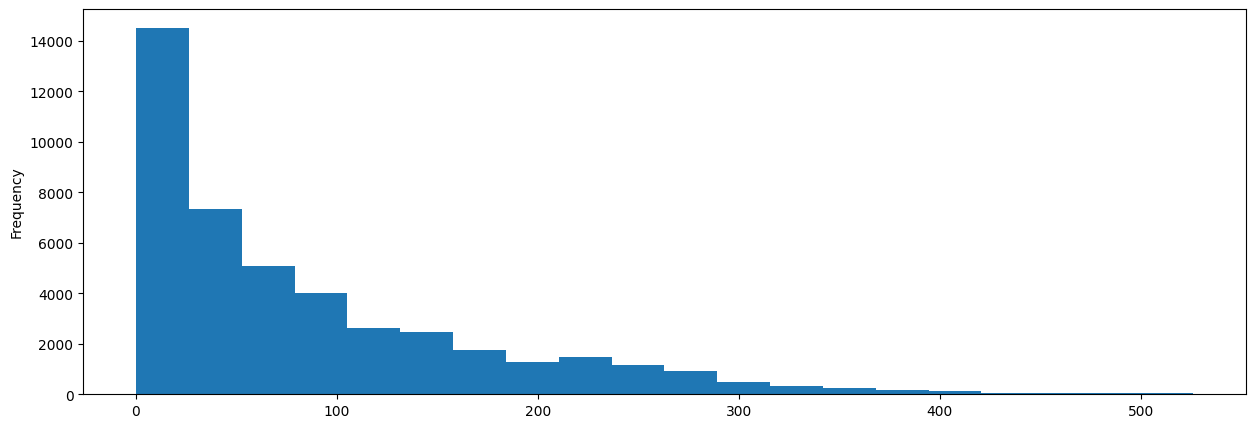

In [26]:
#| include: false

#Plot histogram of days before cancelation
(df.query("is_canceled == 1")
 .assign(days_before_cancelation = lambda x: (x['full_arrival_date'] - pd.to_datetime(x['reservation_status_date'])).dt.days)['days_before_cancelation']
 .plot(kind='hist', figsize=(15,5), bins=20));

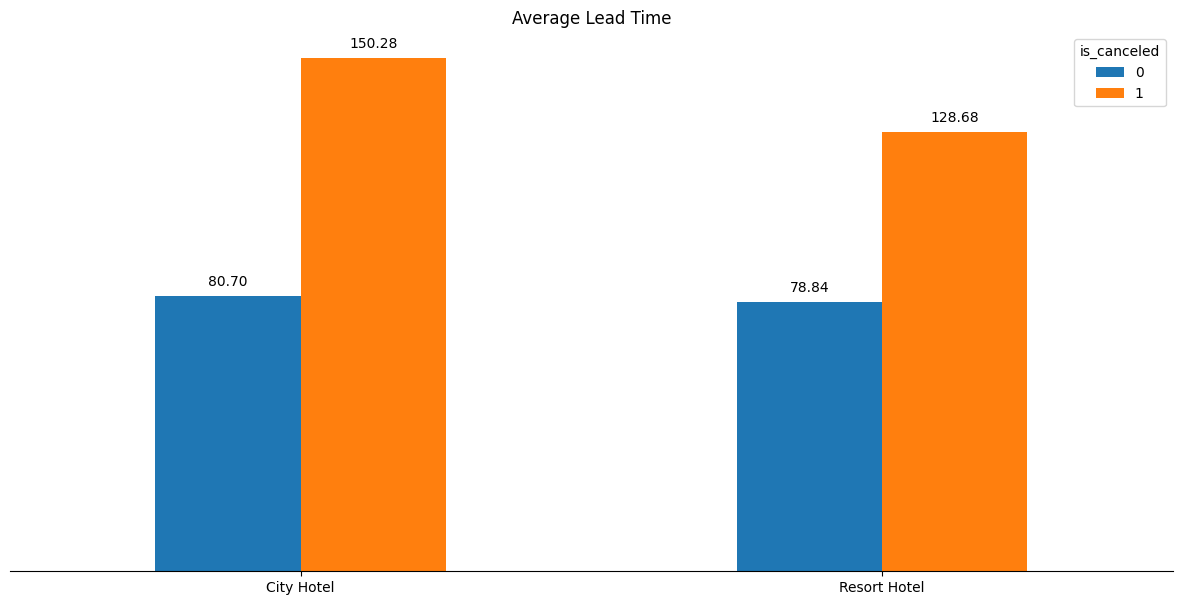

In [27]:
#| label: fig-canceled-det-1
#| fig-cap: "Bar plot of average lead time split by hotel type and booking status"

#Look at average lead time grouped by is_canceled and hotel type
fig, ax = plt.subplots()

df.groupby(['hotel', 'is_canceled'])['lead_time'].mean().unstack().plot(kind='bar', ax=ax, figsize=(15,7),
                                                                        title="Average Lead Time")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines[['right', 'left', 'top']].set_visible(False)
ax.set_yticks([])
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

From @fig-canceled-det-1, we see that there is a large discrepancy between average lead time between non-canceled and canceled bookings. Particulary, in the city hotel, the canceled bookings nearly have double the lead time on average compared to non-canceled bookings. To further dive into the details of the relationship between canceled bookings and lead time, @fig-canceled-det-2 shows the average lead time broken down by how the booking was created (through what marketing channel) split by hotel type and booking status.

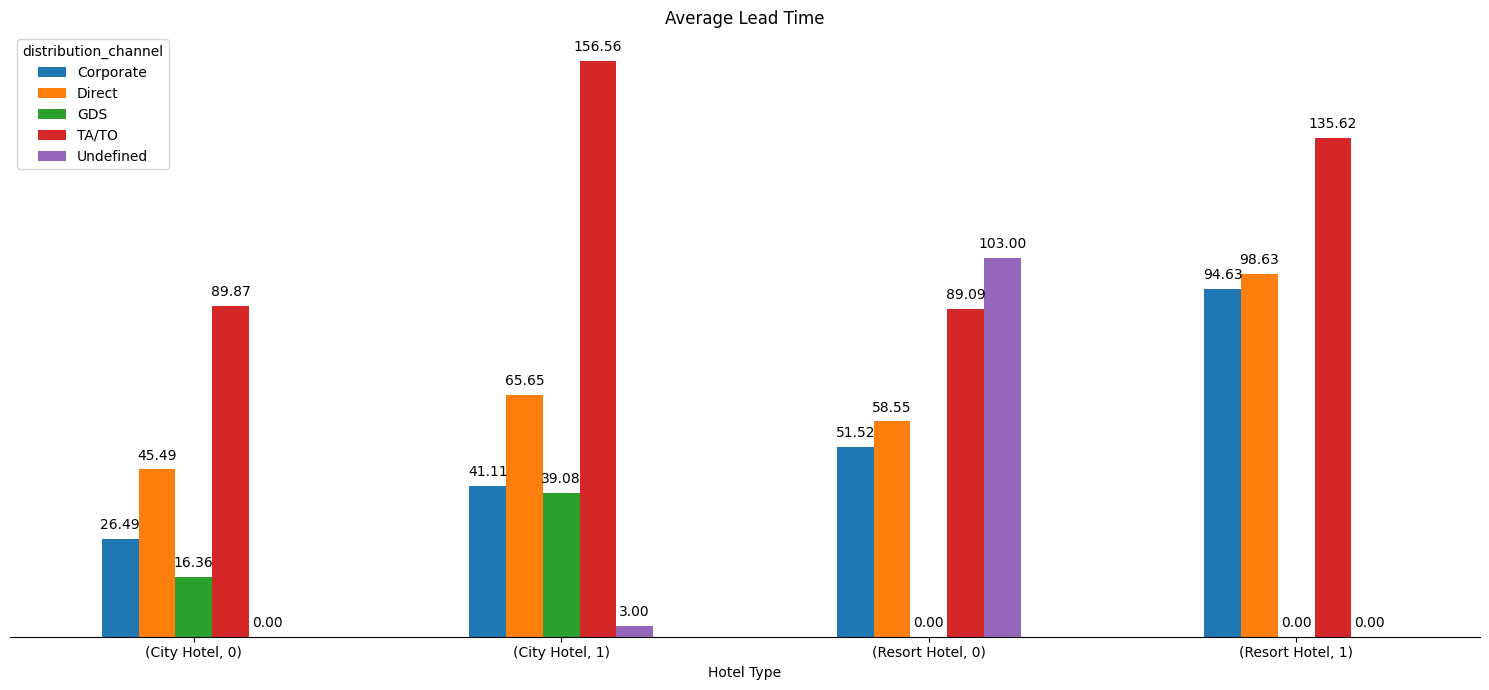

In [28]:
#| label: fig-canceled-det-2
#| fig-cap: "Bar plot of average lead time split by hotel type, distribution channel, and booking status."

#Look at average lead time grouped by is_canceled, hotel type, and distribution_channel
fig, ax = plt.subplots()

df.groupby(['hotel', 'is_canceled', 'distribution_channel'])['lead_time'].mean().unstack().plot(kind='bar', ax=ax, figsize=(15,7),
                                                                        title="Average Lead Time")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines[['right', 'left', 'top']].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('Hotel Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout();

The barplots marked with 0s are bookings that were non-canceled and the barplots with 1s are bookings that were canceled (ie (City Hotel, 0) is average lead time for bookings that were not canceled). As we can see there are still large discrepancies between not canceled and canceled bookings, especially for the city hotel. The TA/TO distribution channel appears to generate the largest lead times for canceled bookings in both the city hotel and the resort hotel.

# Proposed Strategy

To aid TA-MU Hotels reach greater profitability, we propose that we attack the problem of canceled bookings by following a common approach in the airline business: overbooking hotels by predicting cancelations/no-shows. We will approach this problem by first identifying our target market for this approach and later elaborate and demonstrate the effectiveness of a predictive model to implement this strategy.

## Target Market

As noted in @tbl-lost-rev-1 and @tbl-client-1, over 50% of TA-MU bookings are generated by a single demographic: two adults, transient, no kids. To help TA-MU Hotels become more profitable, we propose that we priortize this demographic for the remainder of the report with the goal of minimizing the effects of canceled bookings and maximizing profits from this primary demographic.  

To confirm our findings from the canceled bookings detail section, we run the same analyses performed in that section but just on our focused demographic. @fig-target-1 shows the average lead time split by hotel type for non-canceled and canceled bookings, focused on our primary demographic.

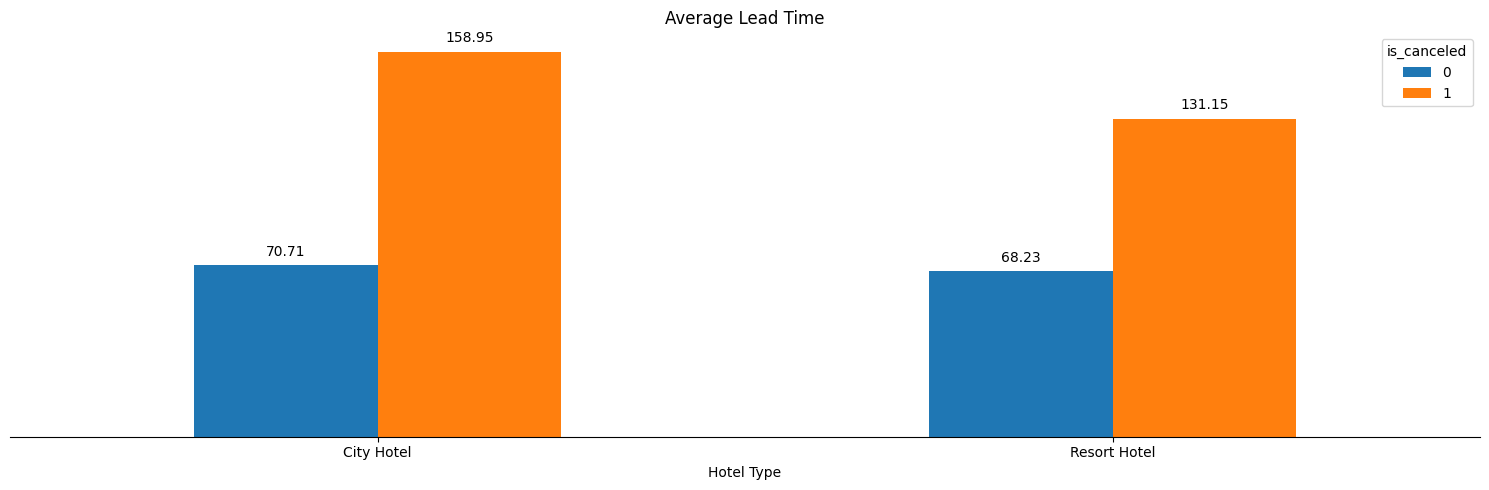

In [29]:
#| label: fig-target-1
#| fig-cap: "Bar plot of average lead time split by hotel type and booking status."

#Look at average lead time for just focused demographic
fig, ax = plt.subplots(figsize=(15,5))

(df.query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .query("adr > 0")
 .assign(days_before_cancelation = lambda x: (x['full_arrival_date'] - pd.to_datetime(x['reservation_status_date'])).dt.days)
 .assign(total_nights = lambda x: x['stays_in_weekend_nights'] + x['stays_in_week_nights'])
 .groupby(['hotel', 'is_canceled'])
 .agg({'lead_time':'mean', 'total_nights':'mean'})
 .reset_index()
 .pivot_table(index='hotel', columns='is_canceled', values=['lead_time', 'total_nights'])
 .plot(kind='bar', y='lead_time', ax=ax)
)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines[['right', 'left', 'top']].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('Hotel Type')
ax.set_title("Average Lead Time")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout();

As we can see in @fig-target-1, we confirm that the discrepancies between lead time of non-canceled and canceled bookings exist for our primary demographic. To get a further detailed view of where our primary demographic cancels their bookings, we plot in @fig-target-2 the percent of canceled bookings split by distribution channel and hotel type.

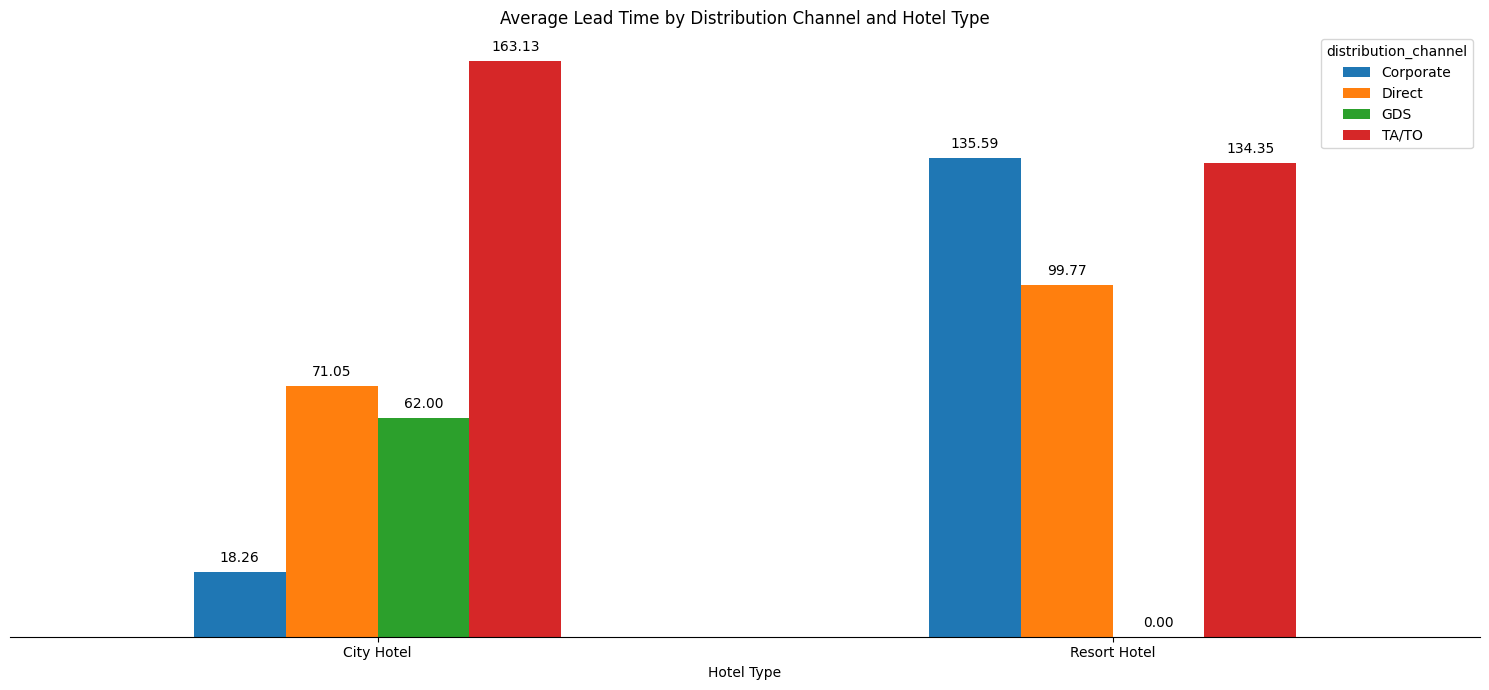

In [30]:
#| include: false

#Look at average lead time by distribution channel for focused demographic (canceled only)
fig, ax = plt.subplots()

(df.query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .query("is_canceled == 1")
 .groupby(['hotel', 'distribution_channel'])['lead_time'].mean()
 .unstack()
 .plot(kind='bar', ax=ax, figsize=(15,7), title="Average Lead Time by Distribution Channel and Hotel Type")
)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines[['right', 'left', 'top']].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('Hotel Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout();

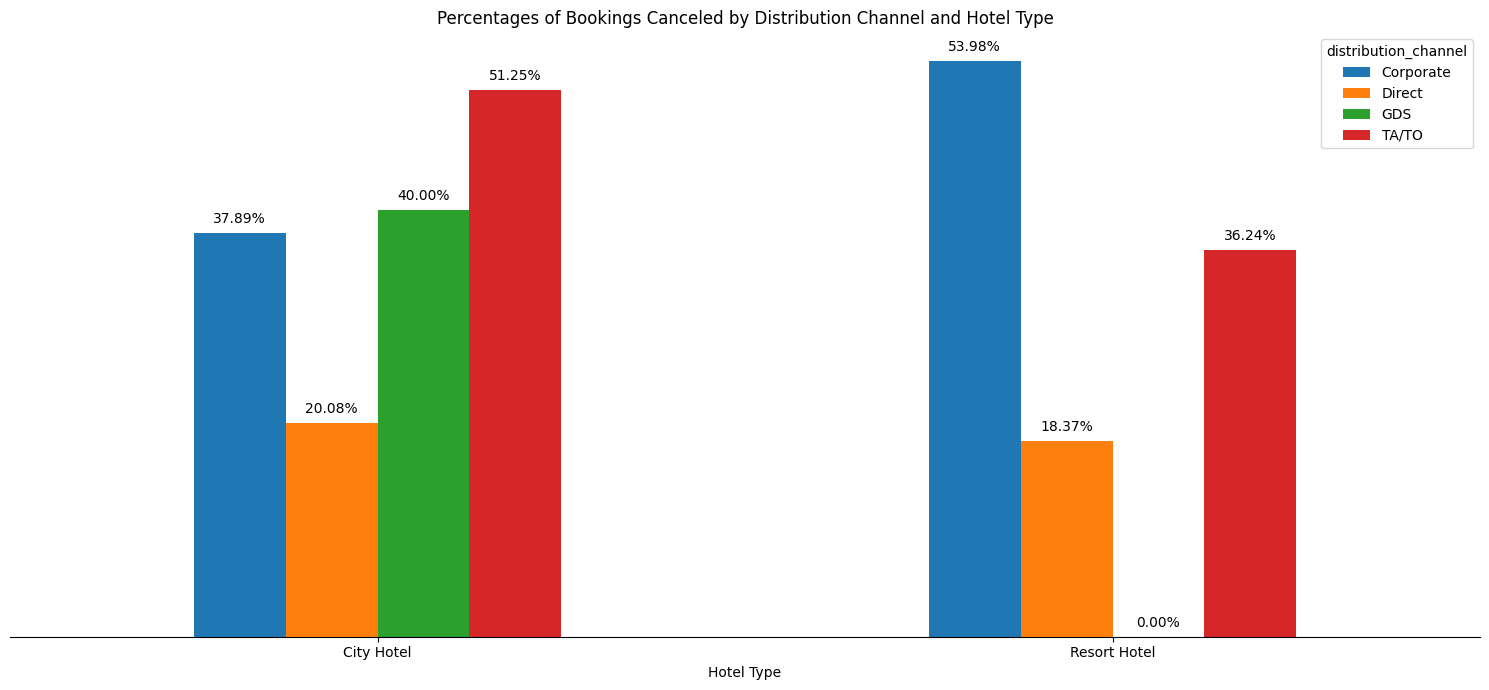

In [31]:
#| label: fig-target-2
#| fig-cap: "Bar plot of % bookings canceled split by hotel type and marketin distribution channel."

#Look at proportion of cancelations for each distribution channel by hotel for focused demographic
fig, ax = plt.subplots()

(df.query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .query("distribution_channel != 'Undefined'")
 .groupby(['hotel', 'distribution_channel'])['is_canceled'].mean()
 .unstack()
 .apply(lambda x: x * 100)
 .plot(kind='bar', ax=ax, figsize=(15,7), title="Percentages of Bookings Canceled by Distribution Channel and Hotel Type")
)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.spines[['right', 'left', 'top']].set_visible(False)
ax.set_yticks([])
ax.set_xlabel('Hotel Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout();

It appears that for our primary demographic (two adults, transient, no kids in booking), the highest percentage of cancellations for the city hotel are bookings made through the TA/TO channel. For the resort hotel, the highest percentage of cancellations are bookings made through the corporate channel.

# Predictive Model for Cancelations (primary demographic only)

To aid TA-MU Hotels in their quest to reach greater profitability, we propose creating a model that predicts whether a booking will be canceled or not. This model will aid in helping management know whether or not hotels are booked to capacity and if they can continue to take reservations to increase the likelihood of generating revenue for non-canceled bookings.

## Data Setup

We begin the process of creating a good predictive model by ensuring that the data we feed the model is accurate and useful. To do this, we dropped irrelevant columns to our analysis and filter it to include only data pertaining to our primary demographic. Additionally, we create dummy variable columns in order to account for factors in our model (i.e. distribution channel). The result of our data cleaning and feature engineering is a change from raw data of 119390 rows of data and 37 columns to training data of 61024 rows and 24 columns of data.

In [32]:
#Drop unnecessary columns for model
df_mod = (df.query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'children',
        'babies', 'country', 'market_segment', 'assigned_room_type', 'agent', 'company', 'customer_type',
        'adr', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'name',
        'email', 'phone-number', 'credit_card', 'full_arrival_date', 'adults', 'meal', 'arrival_date_month'], axis=1)
)

In [33]:
#Get dummy variables
df_mod = (pd.get_dummies(df_mod, columns=['distribution_channel', 'is_repeated_guest',
                                         'reserved_room_type', 'deposit_type', 'hotel',
                                          'is_canceled'], drop_first=True, dtype=float)
          .rename(columns={'is_canceled_1':'is_canceled'})
         )

In [34]:
#Split x and y
X = df_mod.drop('is_canceled', axis=1)
y = df_mod['is_canceled']

#Add interaction terms
#interact_fit = PolynomialFeatures(interaction_only=True, include_bias=False)
#X = interact_fit.fit_transform(X)

In [35]:
#Standardize features and add constant
scaler = StandardScaler()
X = scaler.fit_transform(X)

To help our model more accurately predict cancelations, we use a standard scaler to standardize each column of data. This will help the model recognize each feature as a normally distributed variable. Furthermore, to help determine the predictive capability of our model, we use a train-test split of 75% training and 25% test data. This allocation is randomly done by the train_test_split function provided in scikit-learn.

In [36]:
#Split into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Selection

In order to determine whether or not we should use the full dataset of 24 features for our model or if a subset of these features would be adequate, we perform forward stepwise selection using a logistic regression model. The results of our model selection procedure are found below.

In [37]:
#Load sfs_support
with open('sfs_support.pkl', 'rb') as file:
    sfs_sup = pickle.load(file)
    file.close()

In [38]:
#Show model selection results
df_mod.drop("is_canceled", axis=1).loc[:,sfs_sup].columns

Index(['lead_time', 'stays_in_weekend_nights', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'required_car_parking_spaces', 'distribution_channel_TA/TO',
       'reserved_room_type_E', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'hotel_Resort Hotel'],
      dtype='object')

These 11 features, according to forward stepwise selection, are the features that provide the greatest additional improvement to the model. To test this theory, we compared a logistic regression model with these 11 features against a logistic regression model with all 24 features. The results show that the models performed equally as well at predictive accuracy (both around 75%). We determine that using less features is more computationally efficient for similar predictive accuracy so we will use the 11 features that we found with the forward stepwise selection for the remainder of the iterative process of building a predictive model.

In [39]:
# #Perform forward selection on logistic regression model
# log_reg = LogisticRegression()
# sfs = SequentialFeatureSelector(log_reg, direction='forward')
# sfs.fit(X_train, y_train)

In [40]:
# #Check what features remain
# (df_mod.drop("is_canceled", axis=1)
#  .loc[:,sfs.get_support()])

In [41]:
# #Save sfs_support
# with open('sfs_support.pkl', 'wb') as file:
#     pickle.dump(sfs.get_support(), file)

In [42]:
# #Try trimmed model
# X_2 = sfs.transform(X)

In [43]:
# #Save X_2
# with open('x_feat.pkl', 'wb') as file:
#     pickle.dump(X_2, file)

In [44]:
#Load X_2
with open('x_feat.pkl', 'rb') as file:
    X_2 = pickle.load(file)
    file.close()

In [45]:
#Add interaction between distribution channel and lead_time and distribution channel and hotel_resort Hotel
int_lead = X_2[:,0] * X_2[:,6]
int_hotel = X_2[:,10] * X_2[:,6]

X_2 = np.column_stack((X_2, int_lead))
X_2 = np.column_stack((X_2, int_hotel))

In [46]:
#Get new train test splits
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.25, random_state=42)

### Additional Features

As noted previously in the report, there could be interactions between some of these features. For example, the effect that lead time has on the probability of a cancelation might change based on the kind of distribution channel the lead came from. Therefore, we will add two extra features to current subset of 11 features for our predictive model: interaction between distribution channel and lead time, and interaction between distribution channel and hotel type.

## Model Comparisons

### Logistic Regression

We begin with logistic regression to see if this kind of model performs well at predicting cancelations. After fitting our training data to our logistic regression model, we obtainthe following results.

In [47]:
#Fit logistic regression model
mod_2 = sm.GLM(y_train_2, sm.add_constant(X_train_2, has_constant='add'), family=sm.families.Binomial()).fit()

In [48]:
#Get summary of trimmed model
mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_canceled   No. Observations:                45768
Model:                            GLM   Df Residuals:                    45754
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21165.
Date:                Thu, 25 Apr 2024   Deviance:                       42330.
Time:                        13:11:47   Pearson chi2:                 3.81e+07
No. Iterations:                    28   Pseudo R-squ. (CS):             0.3573
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5268   3333.240      0.001      0.999   -6530.503    6535.557
x1             0.5459      0.016     33.679      0.000       0.514       0.578
x2            -0.0389      0.012     -3.250      0.001      -0.062      -0.015
x3             1.9948      0.127     15.751      0.000       1.747       2.243
x4            -0.6542      0.061    -10.808      0.000      -0.773      -0.536
x5            -0.1151      0.013     -8.943      0.000      -0.140      -0.090
x6            -7.3338   6598.810     -0.001      0.999   -1.29e+04    1.29e+04
x7             0.2570      0.016     16.150      0.000       0.226       0.288
x8             0.0512      0.012      4.387      0.000       0.028       0.074
x9            11.0061   6281.574      0.002      0.999   -1.23e+04    1.23e+04
x10            0.4591   6533.082   7.03e-05      1.000   -1.28e+04    1.28e+04
x11           -0.0209      0.013     -1.658      0.097      -0.046       0.004
x12            0.0620      0.019      3.326      0.001       0.025       0.099
x13           -0.0320      0.013     -2.467      0.014      -0.057      -0.007
==============================================================================
"""

Features x1, x3, x7, x8, and x12 (lead time, previous cancellations, distribution channel TA/TO, reserved room type E, interaction between lead time and distribution channel TA/TO) show an increase in the log-odds of a cancelation and appear to be statistically significant (alpha = 0.05). Conversely, x2, x4, x5, and x13 (stays in weekend nights, previous bookings not canceled, booking changes, and interaction between distribution channel TA/TO and hotel type) show a decrease in the log-odds of a cancelation.

Using this fitted logistic regression model, we can generate predictions and see how the model does at predicting cancelations using our test data. One metric to test the predictive capability of a classification type model is using a ROC curve and computing the AUC score from it. @fig-log-model-1 shows the corresponding ROC curve and AUC score.

In [49]:
#Get predictions
y_preds_2 = mod_2.predict(sm.add_constant(X_test_2, has_constant='add'))

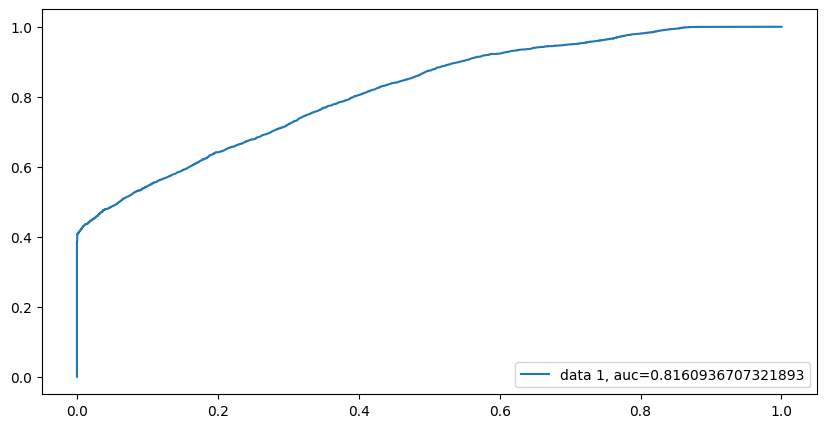

In [50]:
#| label: fig-log-model-1
#| fig-cap: "ROC curve for logistic regression model."

#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test_2,  y_preds_2)
auc = metrics.roc_auc_score(y_test_2, y_preds_2)
plt.figure(figsize=(10,5))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show();

The ROC curve in @fig-log-model-1 shows that the model achieves an AUC score of about .82, indicating that the model does a pretty good job at distinguishing between a canceled booking and a non-canceled booking. Using this graph, we can extract the optimal threshold that minimizes our false positive rate while still achieveing a max true positive rate. Using this threshold, we can construct a confusion matrix to gain further inference on how the model performs on discovering cancelations. @fig-log-model-2 shows the resulting confusion matrix.

In [51]:
#| output: false

#Identify optimal threshold
optimal_thresh_2 = thresholds[np.argmax(tpr - fpr)]
print(optimal_thresh_2)

0.4481688764983439


In [52]:
#Evaluate predictions by comparing labels
y_preds_labels_2 = np.zeros(len(y_preds_2))
y_preds_labels_2[y_preds_2 > optimal_thresh_2] = 1

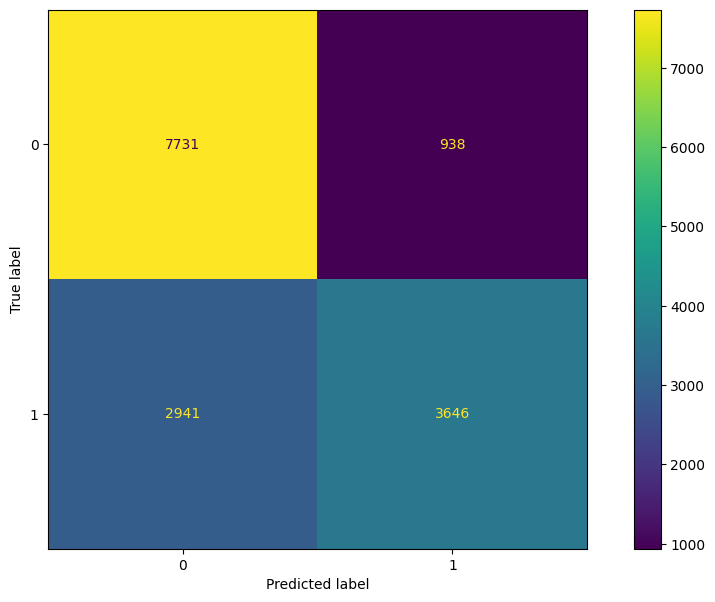

In [53]:
#| label: fig-log-model-2
#| fig-cap: "Confusion matrix for logistic regression model."

#Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_2, y_preds_labels_2)
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
cm_plot.plot(ax=ax);

From the confusion matrix, we see that the logistic regression model does a very good job at identifying non-canceled bookings, but does not perform as well at identifying canceled bookings. However, while the performance does drop significantly between canceled and non-canceled booking classification, the majority of the time the model does predict the correct label for canceled bookings. To view more specific metrics from the confusion table, we can view @tbl-log-mod-1.

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 55% |
| Specificity | 89% |
| PPV | 80% |
| NPV | 72% |

: Logistic Regression Metrics {#tbl-log-mod-1}

In [54]:
#| output: false

#Calculate classification metrics
print("Accuracy: ", np.mean(y_test_2.to_numpy() == y_preds_labels_2))
print("Sensitivity: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0]), 4))
print("Specificity: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[0,1]), 4))
print("PPV: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1]), 4))
print("NPV: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0]), 4))

Accuracy:  0.7457393812270582
Sensitivity:  0.5535
Specificity:  0.8918
PPV:  0.7954
NPV:  0.7244


From @tbl-log-mod-1, we see that our logistic regression model performed well in every category except sensitivity. Even then, the sensitivity score is an acceptable one since the majority of the time it correctly labels a cancelation.

### Random Forest

We now compare a tree based method approach to logistic regression by using a random forest. As we performed above, we will fit a random forest with the same training data and gather predictive metrics (AUC score, confusion matrix metrics) by using the same test set as the logistic regression model. @fig-rf-mod-1 shows the ROC curve and corresponding AUC score for the random forest model.

In [55]:
#| output: false

#Train random forest model
rf_model = RandomForestClassifier(random_state=141)
rf_model.fit(X_train_2, y_train_2)

RandomForestClassifier(random_state=141)

In [56]:
#Get predictions
y_preds_rf = rf_model.predict(X_test_2)

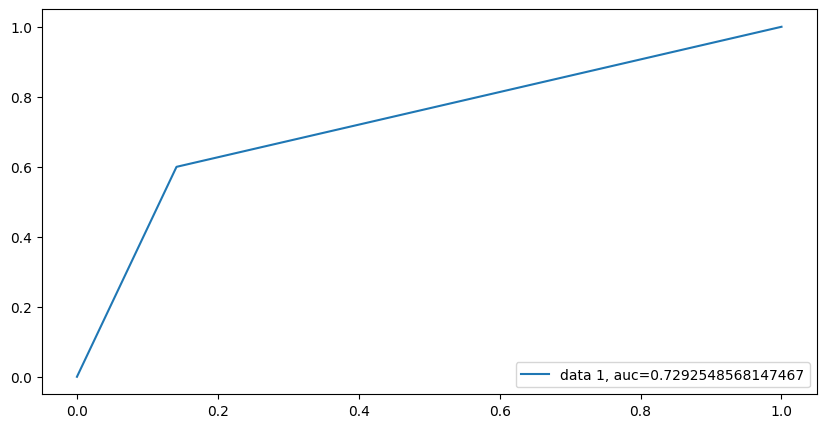

In [57]:
#| label: fig-rf-mod-1
#| fig-cap: "ROC curve and AUC score for random forest model."

#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test_2,  y_preds_rf)
auc = metrics.roc_auc_score(y_test_2, y_preds_rf)
plt.figure(figsize=(10,5))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

From @fig-rf-mod-1, we see that the random forest model yielded a worse AUC score than the logistic regression model. We will check the resulting confusion matrix metrics for further comparison. @fig-rf-mod-2 contains the confusion matrix and @tbl-panel-rf shows the resulting metrics from the confusion matrix.

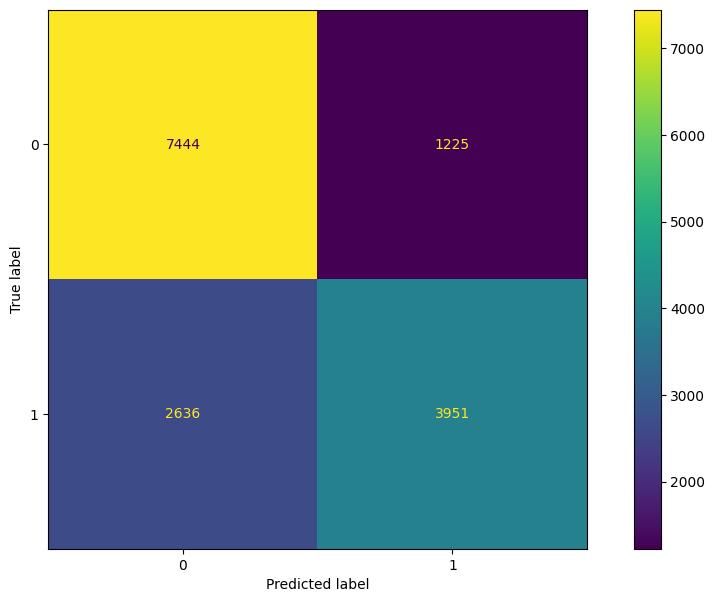

In [58]:
#| label: fig-rf-mod-2
#| fig-cap: "Confusion matrix for random forest model."

#Plot confustion matrix for RF
confusion_matrix_rf = metrics.confusion_matrix(y_test_2, y_preds_rf)
cm_plot_rf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
cm_plot_rf.plot(ax=ax);

:::{#tbl-panel-rf layout-ncol=2}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 60% |
| Specificity | 86% |
| PPV | 76% |
| NPV | 74% |

: Random Forest Metrics {#tbl-rf-mod-1}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 55% |
| Specificity | 89% |
| PPV | 80% |
| NPV | 72% |

: Logistic Regression Metrics {#tbl-log-mod-2}

Random Forest Model vs Logistic Regression Model
:::

In [59]:
#| output: false

#Calculate classification metrics
print("Accuracy: ", np.mean(y_test_2.to_numpy() == y_preds_rf))
print("Sensitivity: ", round(confusion_matrix_rf[1,1] / (confusion_matrix_rf[1,1] + confusion_matrix_rf[1,0]), 4))
print("Specificity: ", round(confusion_matrix_rf[0,0] / (confusion_matrix_rf[0,0] + confusion_matrix_rf[0,1]), 4))
print("PPV: ", round(confusion_matrix_rf[1,1] / (confusion_matrix_rf[1,1] + confusion_matrix_rf[0,1]), 4))
print("NPV: ", round(confusion_matrix_rf[0,0] / (confusion_matrix_rf[0,0] + confusion_matrix_rf[1,0]), 4))

Accuracy:  0.7469192448872575
Sensitivity:  0.5998
Specificity:  0.8587
PPV:  0.7633
NPV:  0.7385


From @tbl-rf-mod-1 and comparing these values to @tbl-log-mod-2, the random forest model performed very similarily to the logistic regression model. The random forest model achieved a higher sensitivity score while dropping in the specificity score. Additionally, the random forest model dropped in PPV but gained in NPV.

### XGBoost

Since the random forest model did not appear to beat out the performance of the logistic regression model, we will now perform a comparison between XGBoost classification and the logistic regression model. We will perform the same procedures as done with the logistic regression model and the random forest model. @fig-xg-mod-1 shows the resulting ROC curve and corresponding AUC score.

In [60]:
#| output: false

#Train XGBoost
xg_mod = XGBClassifier()
xg_mod.fit(X_train_2, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
#Get predictions
y_preds_xg = xg_mod.predict(X_test_2)

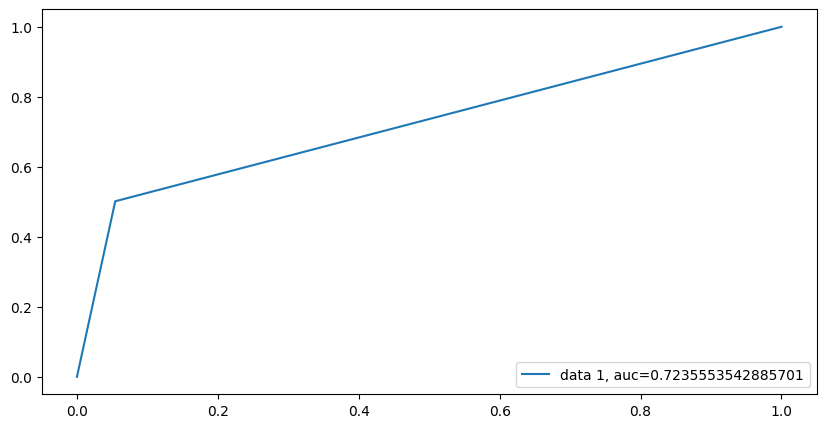

In [62]:
#| label: fig-xg-mod-1
#| fig-cap: "ROC curve and AUC score for XGBoost model"

#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test_2,  y_preds_xg)
auc = metrics.roc_auc_score(y_test_2, y_preds_xg)
plt.figure(figsize=(10,5))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The AUC score for the XGBoost model appears to be very similar to the random forest model, and consequently is much lower than the logistic regression model AUC. @fig-xg-mod-2 and @tbl-panel-xg show the resulting confusion matrix and corresponding metrics.

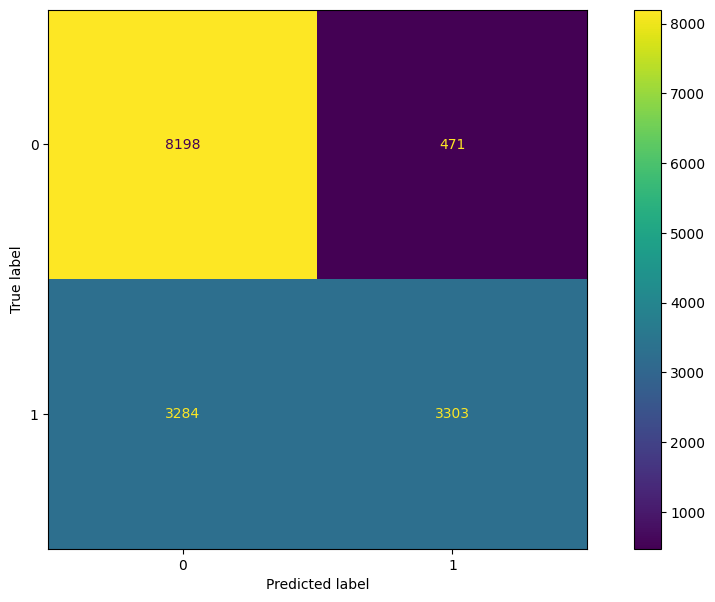

In [63]:
#| label: fig-xg-mod-2
#| fig-cap: "Confusion matrix for XGBoost model."

#Plot confustion matrix for XG
confusion_matrix_xg = metrics.confusion_matrix(y_test_2, y_preds_xg)
cm_plot_xg = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_xg, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
cm_plot_xg.plot(ax=ax);

In [64]:
#| output: false

#Calculate classification metrics
print("Accuracy: ", np.mean(y_test_2.to_numpy() == y_preds_xg))
print("Sensitivity: ", round(confusion_matrix_xg[1,1] / (confusion_matrix_xg[1,1] + confusion_matrix_xg[1,0]), 4))
print("Specificity: ", round(confusion_matrix_xg[0,0] / (confusion_matrix_xg[0,0] + confusion_matrix_xg[0,1]), 4))
print("PPV: ", round(confusion_matrix_xg[1,1] / (confusion_matrix_xg[1,1] + confusion_matrix_xg[0,1]), 4))
print("NPV: ", round(confusion_matrix_xg[0,0] / (confusion_matrix_xg[0,0] + confusion_matrix_xg[1,0]), 4))

Accuracy:  0.7538673308862087
Sensitivity:  0.5014
Specificity:  0.9457
PPV:  0.8752
NPV:  0.714


:::{#tbl-panel-xg layout-ncol=2}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 50% |
| Specificity | 95% |
| PPV | 88% |
| NPV | 71% |

: XGBoost Metrics {#tbl-xg-mod-1}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 55% |
| Specificity | 89% |
| PPV | 80% |
| NPV | 72% |

: Logistic Regression Metrics {#tbl-log-mod-3}

XGBoost vs Logistic Regression Model
:::

From @tbl-panel-xg, we see that XGBoost improves in specificity over the logistic regression model, but decreases at almost the same degree in sensitivity. There is also a large jump in PPV and a slight decline in NPV for XGBoost over logistic regression.

### Bayesian Logistic Regression

Thus far we have attempted to compare the logistic regression model to more ensemble-esque methods. We now attempt to demonstrate a different approach to the logistic regression model by incorporating priors on each feature. That is, we will perform a bayesian logistic regression to compare to the normal logistic regression method.

Due to our limited subject matter expertise in the hotel industry, we will use uninformative priors for each feature. We will assume that each feature is drawn from a normal distribution with mean = $\mu$ and standard deviation = $\sigma$. For each $\mu$, we will place a prior of a normal distribution with $\mu$ = 0 and $\sigma$ = 2. For each $\sigma$, we will place a prior of a inverse gamma distribution with $\alpha$ = 1 and $\beta$ = 1.

For our sampler, we will use a Hamiltonian Monte Carlo with Energy Conserving Sampling. This is chosen due to the size of our dataset and the lack of sufficient computational power to perform a more precise sampling with sampler such as the No-U Turn sampler. After fitting our bayesian logistic regression model, we obtain the following results in @fig-bay-mod-1.

In [65]:
#| warning: false

#Initialize rng_key
rng_key = random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [66]:
#Initialize bayesian logistic model
def bayes_log(X_vars, y_res):
    X_temp = jnp.hstack([jnp.ones((X_vars.shape[0], 1)), X_vars])

    #Initialize priors for beta
    sigma = numpyro.sample("sigma", dist.InverseGamma(1,1))
    mu = numpyro.sample("mu", dist.Normal(0,2))

    #Sample beta
    beta = numpyro.sample("beta", dist.Normal(loc=mu, scale=sigma).expand([X_temp.shape[1]]))

    #Perform logits
    logits = jnp.dot(X_temp, beta)

    with numpyro.plate("data", X_temp.shape[0]):
        numpyro.sample("obs", dist.Bernoulli(logits), obs=y_res)

In [67]:
#Define HMCECS fucntion
def bayes_log_ecs(X_vars, y_res=None):
    #Add intercept to X matrix
    X_temp = jnp.hstack([jnp.ones((X_vars.shape[0], 1)), X_vars])

    #Initialize priors for beta
    sigma = numpyro.sample("sigma", dist.InverseGamma(1,1))
    mu = numpyro.sample("mu", dist.Normal(0,2))

    #Sample beta
    beta = numpyro.sample("beta", dist.Normal(loc=mu, scale=jnp.sqrt(sigma)).expand([X_temp.shape[1]]))

    with numpyro.plate("data", X_temp.shape[0], subsample_size=2500):
        batch_x = numpyro.subsample(X_temp, event_dim=1)
        if y_res is None:
            batch_y = None
        else:
            batch_y = numpyro.subsample(y_res, event_dim=0)
        #logits = jnp.dot(batch_x, beta)
        numpyro.sample("obs", dist.Bernoulli(logits=beta @ batch_x.T), obs=batch_y)

In [68]:
# #Initialize HMCECS
# ecs_kernel = HMCECS(NUTS(bayes_log_ecs))
# mcmc_ecs = MCMC(ecs_kernel, num_warmup=1500, num_samples=5000)
# mcmc_ecs.run(rng_key, X_train_2, y_train_2.values)

In [69]:
# #Save mcmc_ecs
# with open('mcmc_ecs.pkl', 'wb') as file:
#     pickle.dump(mcmc_ecs, file)
#     file.close()

In [70]:
#Load mcmc_ecs
with open('mcmc_ecs.pkl', 'rb') as file:
    mcmc_ecs = pickle.load(file)
    file.close()

In [71]:
#| output: false

#Print summary
mcmc_ecs.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.21      0.81      1.11     -0.12      2.42    837.40      1.00
   beta[1]      0.69      0.02      0.69      0.66      0.72   6873.44      1.00
   beta[2]     -0.11      0.01     -0.11     -0.13     -0.09   6142.08      1.00
   beta[3]      9.33      2.05      9.00      6.23     12.25   1133.01      1.00
   beta[4]     -2.23      0.65     -2.12     -3.14     -1.29   1352.93      1.00
   beta[5]     -0.25      0.02     -0.25     -0.28     -0.22   7776.18      1.00
   beta[6]     -3.80      1.79     -3.32     -6.33     -1.60   1026.19      1.00
   beta[7]      0.33      0.02      0.33      0.30      0.36   3757.18      1.00
   beta[8]      0.05      0.01      0.05      0.03      0.07   7107.56      1.00
   beta[9]      5.12      1.61      4.73      3.02      7.24    826.89      1.00
  beta[10]      0.49      3.43      0.54     -5.14      6.15   2196.28      1.00
  beta[11]     -0.04      0

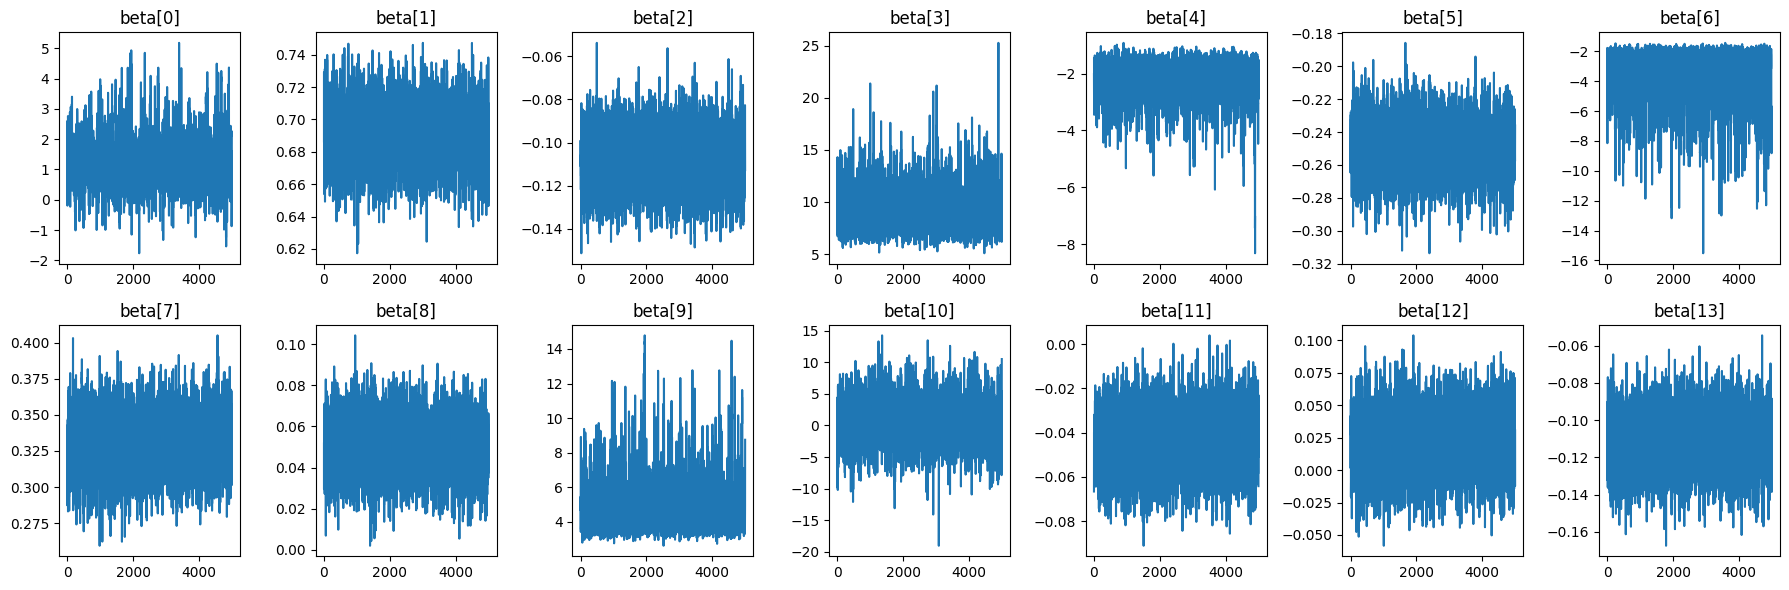

In [72]:
#| output: false

#Plot traces for each beta
fig, axes = plt.subplots(2,7, figsize=(18,6))

for i, ax in enumerate(axes.flatten()):
    ax.plot(mcmc_ecs.get_samples()['beta'][:,i])
    ax.set_title(f"beta[{i}]")

fig.tight_layout();

In [73]:
#Create beta titles
beta_title = (df_mod.drop('is_canceled', axis=1)
 .loc[:,sfs_sup]
 .columns
 .tolist())
beta_title.insert(0,'intercept')
beta_title.append("dist_channel:lead_time")
beta_title.append("dist_channel:hotel_resort")

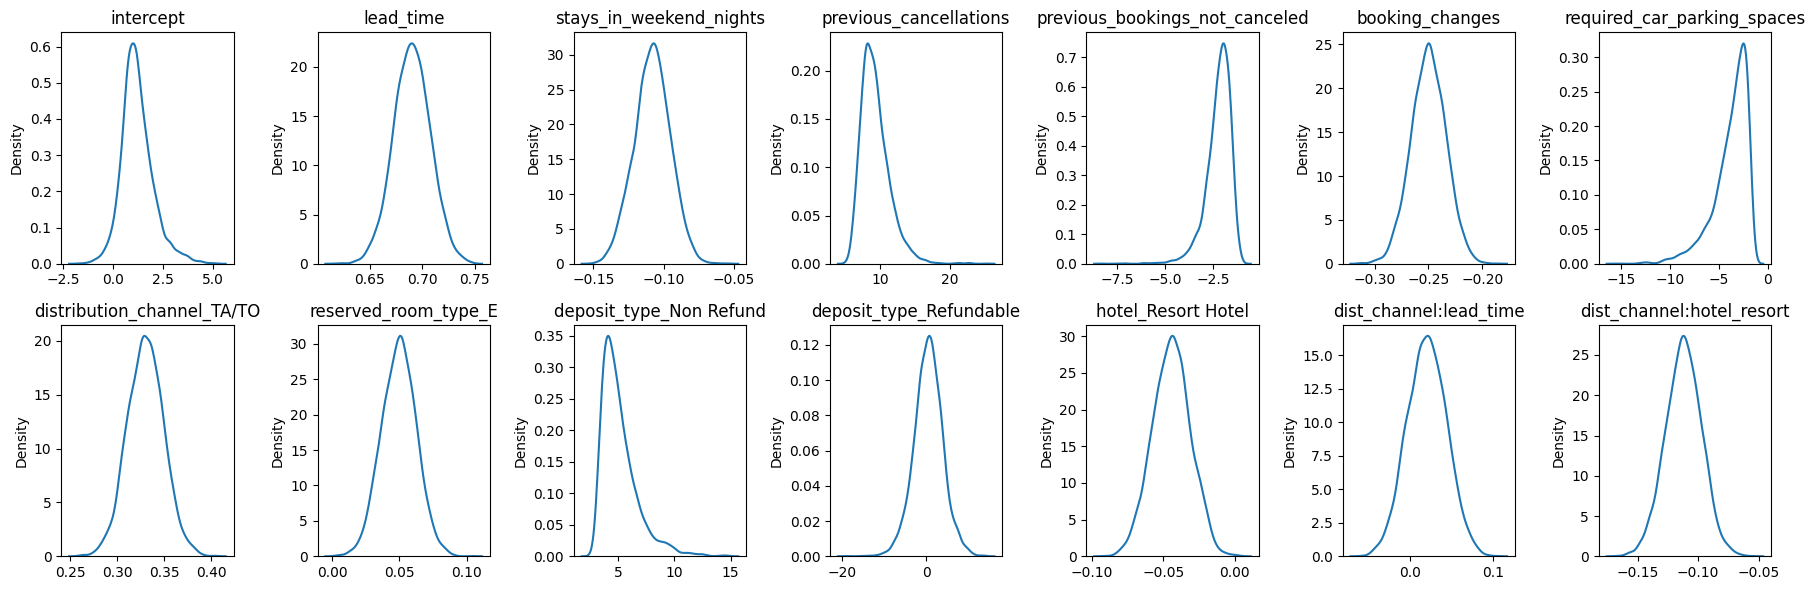

In [74]:
#| label: fig-bay-mod-1
#| fig-cap: "Posterior distributions for each feature."

#Plot posterior for each beta
fig, axes = plt.subplots(2,7, figsize=(18,6))

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(mcmc_ecs.get_samples()['beta'][:,i], ax=ax)
    ax.set_title(f"{beta_title[i]}")

fig.tight_layout();

A benefit of performing a bayesian model is the viewable uncertainty around parameters of interest. In our case, we can see the distributions of each beta value from our model. For example, the change in log-odds on booking status by lead time is likely to be around .7, but can be anywhere between .65 and .75, according to our model. Additionally, our predictions can also have this kind of uncertainty around them. For example, below is information pertaining to a booking that ended up canceling.

In [75]:
#Get all predictions
preds_dict = {}
for i in range(X_test_2.shape[0]):
    preds_dict[i] = np.dot(X_test_2[i,:], mcmc_ecs.get_samples()['beta'][:,1:].T) + mcmc_ecs.get_samples()['beta'][:,0]

In [76]:
#| warning: false

#Get probabilites for each prediction
prob_array = []

for key, values in preds_dict.items():
    avg_val = np.mean(values)
    prob_val = np.exp(avg_val) / (1 + np.exp(avg_val))
    prob_array.append(prob_val)

prob_array = np.array(prob_array)

/tmp/ipykernel_161/2021034982.py:8: RuntimeWarning: overflow encountered in exp
  prob_val = np.exp(avg_val) / (1 + np.exp(avg_val))
/tmp/ipykernel_161/2021034982.py:8: RuntimeWarning: invalid value encountered in scalar divide
  prob_val = np.exp(avg_val) / (1 + np.exp(avg_val))


In [77]:
#Get specific prediction for a cancelation
(df_mod.query("is_canceled == 1")
 .drop(['is_canceled'], axis=1)
 .loc[:,sfs_sup]
 .reset_index(drop=True)
 .loc[10000,:])

lead_time                         110.0
stays_in_weekend_nights             0.0
previous_cancellations              0.0
previous_bookings_not_canceled      0.0
booking_changes                     0.0
required_car_parking_spaces         0.0
distribution_channel_TA/TO          1.0
reserved_room_type_E                0.0
deposit_type_Non Refund             0.0
deposit_type_Refundable             0.0
hotel_Resort Hotel                  0.0
Name: 10000, dtype: float64

We see that there were 110 days between lead entered into system and arrival date, that they were staying in the city hotel (hotel_resort = 0) and that they booked throuh TA/TO. Using our bayesian model, we can view the uncertainty around this prediction, as shown in @fig-bay-mod-2.

In [78]:
#Set up prediction
temp_pred = (df_mod.query("is_canceled == 1")
 .drop(['is_canceled'], axis=1)
 .loc[:,sfs_sup]
 .reset_index(drop=True)
 .loc[10000,:]
 .values
 .reshape(1,-1))

temp_pred = (temp_pred - scaler.mean_[sfs_sup]) / scaler.scale_[sfs_sup]

temp_lead = temp_pred[:,0] * temp_pred[:,6]
temp_hotel = temp_pred[:,10] * temp_pred[:,6]

temp_pred = np.column_stack((temp_pred, temp_lead))
temp_pred = np.column_stack((temp_pred, temp_hotel))

In [79]:
#Generate prediction
temp_logit = np.dot(temp_pred, mcmc_ecs.get_samples()['beta'][:,1:].T) + mcmc_ecs.get_samples()['beta'][:,0]

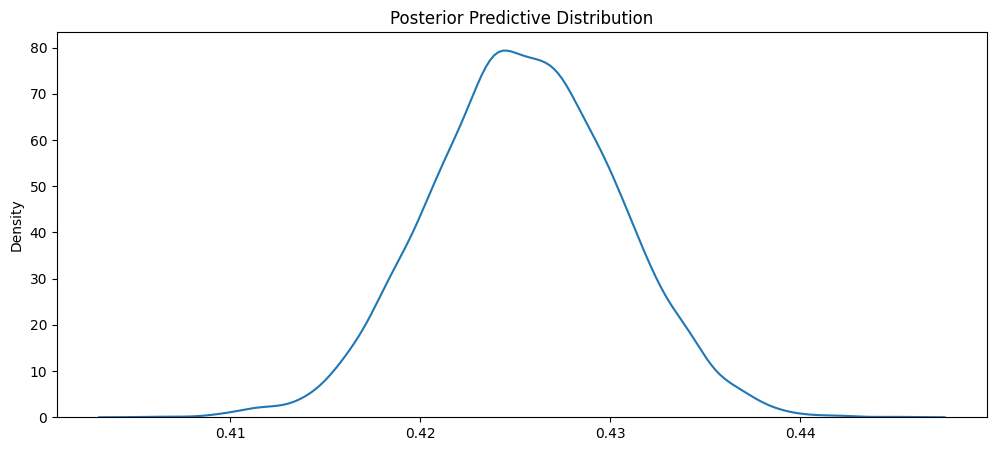

In [80]:
#| label: fig-bay-mod-2
#| fig-cap: "Posterior Predictive Distribution for the described canceled booking."

#Graph prediction
fig, ax = plt.subplots(figsize=(12,5))

t = np.exp(temp_logit) / (1 + np.exp(temp_logit))
sns.kdeplot(t[0], ax=ax)
ax.set_title("Posterior Predictive Distribution");

From @fig-bay-mod-2, we see that the most likely value from the distribution is around .42 to .43. According to the distribution, the probability that somebody with this kind of booking information (from our primary demographic) cancels is around .41 to .44.

While the world of bayesian modeling is fascinating and can be powerful, the goal remains the same of providing a model that could be of use to us in identifying where we need to double book rooms in order to maximize profit for TA-MU Hotels. Just like in the other sections, we will compare the AUC score and derived confusion matrix metrics. @fig-bay-mod-3 shows the ROC curve for our bayesian model.

In [81]:
#Convert nans to 1s
prob_array = np.nan_to_num(prob_array, nan=1)

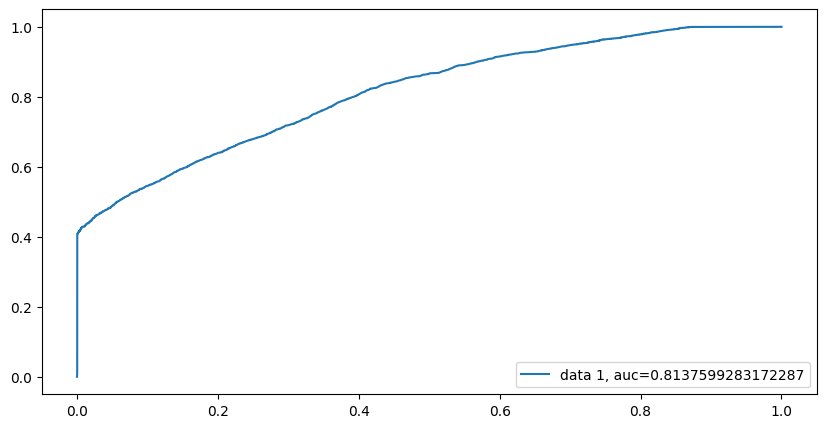

In [82]:
#| label: fig-bay-mod-3
#| fig-cap: "ROC curve and corresponding AUC score for bayesian logistic regression model."

#Get ROC curve and AUC score
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y_test_2,  prob_array)
auc_bayes = metrics.roc_auc_score(y_test_2, prob_array)
plt.figure(figsize=(10,5))
plt.plot(fpr_bayes,tpr_bayes,label="data 1, auc="+str(auc_bayes))
plt.legend(loc=4)
plt.show()

From @fig-bay-mod-3, we see that the AUC score is very similar to the original logistic regression model. @fig-bay-mod-4 shows the corresponding confusion matrix and @tbl-panel-bay show the comparison between the bayesian logistic regression model and the regular logistic regression model.

In [83]:
#| output: false

#Get opt thresh
optimal_thresh_bayes = thresholds_bayes[np.argmax(tpr_bayes - fpr_bayes)]
print(optimal_thresh_bayes)

0.4831196704430455


In [84]:
#Get labels for bayesian predictions
bayes_pred_labels = np.zeros(len(y_test_2))
bayes_pred_labels[prob_array > .48] = 1

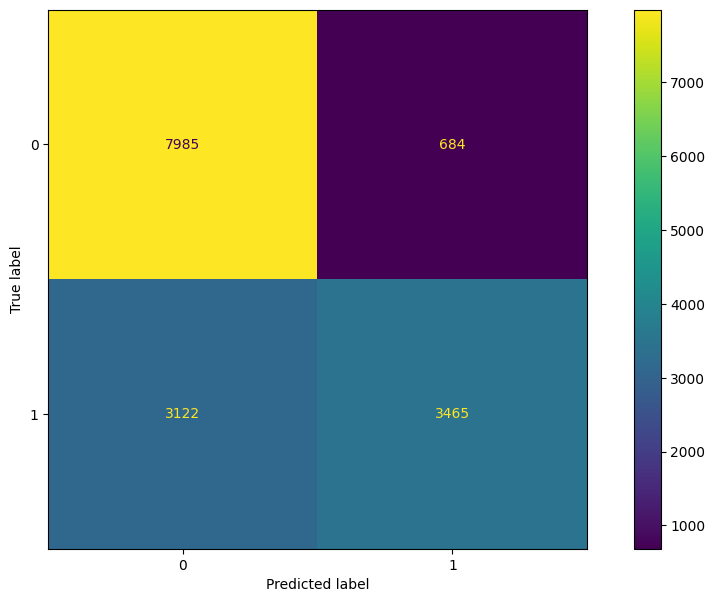

In [85]:
#| label: fig-bay-mod-4
#| fig-cap: "Confusion matrix for bayesian logistic regression model"

#Plot confusion matrix
bayes_confusion_matrix = metrics.confusion_matrix(y_test_2, bayes_pred_labels)
bayes_cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=bayes_confusion_matrix, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
bayes_cm_plot.plot(ax=ax);

In [86]:
#| output: false

print("Accuracy: ", np.mean(y_test_2.values == bayes_pred_labels))
print("Sensitivity: ", round(bayes_confusion_matrix[1,1] / (bayes_confusion_matrix[1,1] + bayes_confusion_matrix[1,0]), 4))
print("Specificity: ", round(bayes_confusion_matrix[0,0] / (bayes_confusion_matrix[0,0] + bayes_confusion_matrix[0,1]), 4))
print("PPV: ", round(bayes_confusion_matrix[1,1] / (bayes_confusion_matrix[1,1] + bayes_confusion_matrix[0,1]), 4))
print("NPV: ", round(bayes_confusion_matrix[0,0] / (bayes_confusion_matrix[0,0] + bayes_confusion_matrix[1,0]), 4))

Accuracy:  0.7505243838489775
Sensitivity:  0.526
Specificity:  0.9211
PPV:  0.8351
NPV:  0.7189


:::{#tbl-panel-bay layout-ncol=2}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 53% |
| Specificity | 92% |
| PPV | 84% |
| NPV | 72% |

: Bayesian Logistic Regression Metrics {#tbl-bay-mod-1}

| Metric Name | Score |
|-------------|-------|
| Accuracy | 75% |
| Sensitivity | 55% |
| Specificity | 89% |
| PPV | 80% |
| NPV | 72% |

: Logistic Regression Metrics {#tbl-log-mod-4}

Bayesian Logistic Regression Model vs Logistic Regression Model
:::

From @tbl-panel-bay, we see that the two models are very similar. The bayesian model shows a slight increase in specificity and a small decrease in sensitivity. The bayesian model also shows an increase in PPV while keeping NPV the same as the regular logistic regression model.

## Model Decision

While all 4fourmodels proved to be viable models worthy of use in our system, the two logistic regression models had higher AUC scores and were more balanced in the sensitivity-specificity trade-off. To decide which logistic regression model to use, we look at the confusion matrix metrics and AUC scores. Both models have similar confusion matrix metrics and AUC scores. However, the bayesian logistic regression model has a particular advantage over the regular logistic regression model due to its inherit ability at including uncertainty around parameter estimates and predictions. Therefore, we recommend that we continue with the bayesian logistic regression model as our initial cancelation predictive model.

The full model for our bayesian logistic regression model is shown in @eq-full-mod-1

$$
\text{log}(\frac{p(Y)}{1-p(Y)}) = \beta_0 + \beta_1x_1 ... + \beta_{m}x_m
$$

$$
\text{Y}_1 ... \text{Y}_n \overset{\text{i.i.d.}}{\sim} \text{Bernoulli}(p)
$$

$$
\beta \sim N(\mu, \sigma)
$$

$$
\mu \sim N(0, 2)
$$

$$
\sigma \sim IG(1, 1)
$${#eq-full-mod-1}

@eq-full-mod-1 states that the log-odds of booking status (1 being cancelation and 0 being non-cancelation) is a linear function of $m$ predictors (our 11 features and two interaction terms) weighted by $m+1$ betas (13 for the features and one intercept beta). Our response variable $Y$ is a collection of n number of i.i.d. Bernoulli random variables with probability $p$. Our betas are assumed to be normally distributed with mean $\mu$ and standard deviation $\sigma$. All $\mu$ values have a normal prior distribution with mean = 0 and standard deviation = 2. All $\sigma$ values have an inverse gamma prior distribution with shape = 1 and scale = 1.

# Example Business Impact

As discussed earlier in the report, the goal of this analysis and resulting predictive model from the analysis is to help TA-MU Hotels reach higher profitability. To do this, we will use the predictive model to determine which future bookings will most likely be canceled and therefore can still be booked, helping TA-MU Hotels become more profitable by having less vacant rooms per day.  

To demonstrate the potential business impact this model can have, consider the following dataset for the city hotel of guests (from our primary demographic) who are supposed to arrive on 06-12-2017. On this date, there are 98 bookings for our primary demographic. Of the 98 bookings, 43 of them canceled. We will use the predictive capability of our model to see how close we can get to this number.

In [87]:
#| output: false

(df.query("full_arrival_date == '2017-06-12' and hotel == 'City Hotel'")
 .query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")['is_canceled']
 .value_counts()
)

is_canceled
0    55
1    43
Name: count, dtype: int64

In [88]:
#Save indices of example dataset
test_ind = (df.query("full_arrival_date == '2017-06-12' and hotel == 'City Hotel'")
 .query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .index
)

In [89]:
#Get values from df_mod
temp_pred = (df_mod.loc[test_ind]
 .drop(['is_canceled'], axis=1)
 .loc[:,sfs_sup]
 .reset_index(drop=True)
 .values)

In [90]:
#Prepare pred dataset
temp_pred = (temp_pred - scaler.mean_[sfs_sup]) / scaler.scale_[sfs_sup]

temp_lead = temp_pred[:,0] * temp_pred[:,6]
temp_hotel = temp_pred[:,10] * temp_pred[:,6]

temp_pred = np.column_stack((temp_pred, temp_lead))
temp_pred = np.column_stack((temp_pred, temp_hotel))

In [91]:
#Generate prediction
temp_logit = np.dot(temp_pred, mcmc_ecs.get_samples()['beta'][:,1:].T) + mcmc_ecs.get_samples()['beta'][:,0]

In [92]:
#Convert to probabilites
temp_probs = np.exp(temp_logit) / (1 + np.exp(temp_logit))

In [93]:
#Convert probabilites to labels
temp_bayes_pred_labels = np.zeros(len(test_ind))
temp_bayes_pred_labels[temp_probs.mean(axis=1) > .48] = 1

In [94]:
#| output: false

#Get number of predicted cancelations
temp_bayes_pred_labels.sum()

30.0

In [95]:
#Save true labels
temp_true_labels = (df.query("full_arrival_date == '2017-06-12' and hotel == 'City Hotel'")
 .query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")['is_canceled']
 .values
)

In [96]:
#| output: false

#Compare true labels to pred labels
(temp_bayes_pred_labels == temp_true_labels).sum()

77

Using just the maximum a posteriori from each posterior predictive distribution, we predicted that 30 of the bookings would have canceled! Additionally, of the 98 bookings, the model got 77 of the 98 booking statuses correct (matched canceled to canceled and non-canceled to non-canceled correctly). While the model is not perfect at predicting every label correctly, because the model underpredicted the number of cancelations, we would still have open rooms to move people to if we ended up double-booking a particular room. While we acknowledge this may have an effect on customer experience, the saved revenue by filling 30 extra rooms is worth the price. As well, with the additional revenue, we can invest some of the increased revenue in helping improve the customer experience.

From our simple business case, @fig-bus-imp-1 shows the revenue generated that day vs potential revenue added if we were to have filled the 30 extra rooms.

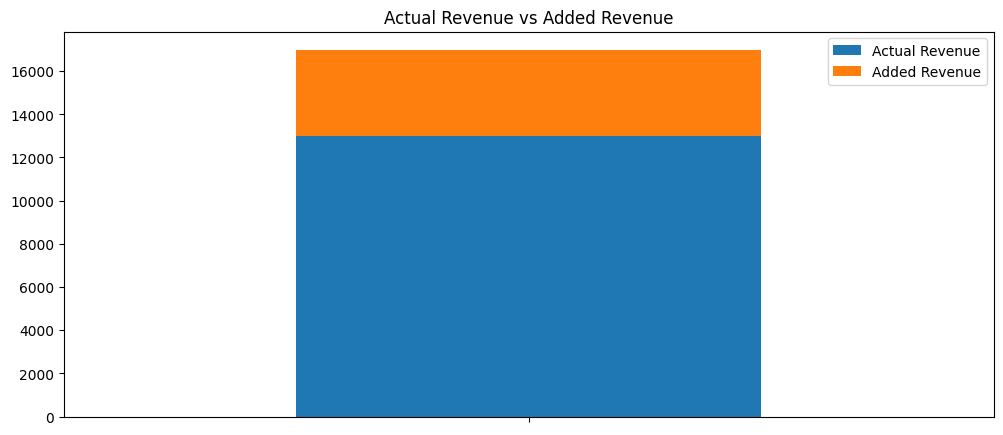

In [97]:
#| label: fig-bus-imp-1
#| fig-cap: "Stacked bar plot showing the revenue generated on 06-12-2017 vs the potential added revenue had we filled the 30 extra rooms predicted by the model. This forecast assumes added revenue is about the average revenue per guest for this day."

#Get average adr for business case day
temp_avg_adr = (df.query("full_arrival_date == '2017-06-12' and hotel == 'City Hotel'")
 .query("adults == 2 and customer_type == 'Transient' and babies == 0 and children == 0")
 .query("is_canceled == 0")['adr']
 .mean()
)

temp_df_adr = pd.DataFrame({'Actual Revenue':[temp_avg_adr*len(temp_true_labels)], 'Added Revenue': [temp_avg_adr*30]})

fig, ax = plt.subplots(figsize=(12,5))

temp_df_adr.plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels("")
ax.set_title("Actual Revenue vs Added Revenue");

In [98]:
#| output: false

(((temp_avg_adr*30) + (temp_avg_adr*len(temp_true_labels))) -  temp_avg_adr*len(temp_true_labels)) / (temp_avg_adr*len(temp_true_labels))

0.3061224489795918

@fig-bus-imp-1 shows that for this particular day in June, we could have seen an additional $3,981 of revenue. This would be approximately a 31% increase in revenue for this one day. While these calculations assume the added revenue would be at least the average of the revenue generated per customer this scenario nonetheless would yield higher profits in the long run for TA-MU Hotels.

# Conclusion

This report demonstrated that TA-MU Hotels is a profitable hotel business operation. We identified how much revenue is generated daily by both hotels, who the main clients are in each, and how much TA-MU Hotels is losing due to canceled bookings and unfilled hotel rooms. We created a predictive model that has the capacity to identify which bookings will be canceled or not canceled, allowing TA-MU Hotels to overbook rooms to generate more revenue.

Next steps include implementing the model into the TA-MU systems to begin the strategic approach of "overbooking" rooms. As well, more refinement can be made with the bayesian logistic regression model, namely: testing new model selection methods to find "better" variables for the model, adjusting criteria for predicting cancelation (i.e. swap to a 95% credible interval range for cancelation labeling), and possibly adding more models to our system to enhance the customer experience (predict repeat bookings, gather inference on customer churn, etc).  